# MORDM - Directed Search over Levers

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import time
import changefont as cf

import os 
os.chdir(os.getcwd())
import sys
# insert at 1, 0 is the script path (or '' in REPL)
pydice_folder = os.path.dirname(os.getcwd())+"\\1_Model"
policy_folder = os.path.dirname(os.getcwd())+"\\5_Policy_Discovery"
sys.path.insert(1, pydice_folder)

from ema_workbench.analysis import parcoords
from ema_workbench.em_framework.optimization import EpsilonProgress
from ema_workbench import (save_results, load_results, Model, Policy, Scenario, 
                           Constraint, RealParameter, IntegerParameter, ScalarOutcome, 
                           MultiprocessingEvaluator, SequentialEvaluator)

from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
from ema_workbench.em_framework.evaluators import BaseEvaluator

ema_logging.log_to_stderr(ema_logging.INFO)
BaseEvaluator.reporting_frequency = 0.1
# ema_logging.log_to_stderr(ema_logging.DEBUG)

from PyDICE_V4 import PyDICE

C:\Users\Shajee\Anaconda3\lib\site-packages\ema_workbench\analysis\prim.py:31: ImportWarning: altair based interactive inspection not available
  "inspection not available"), ImportWarning)
C:\Users\Shajee\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\Shajee\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\Shajee\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
sns.set_context("talk")

In [3]:
f = open("output_scenarioselection.txt", "r")
scenario_txt = f.read()[-26:-6]
scenario_lst = eval(scenario_txt)

In [4]:
# eval('results_'+(str(scenario_lst[0])))
scenario_lst

[102, 354, 467, 473]

In [5]:
results_102 = pd.read_csv("wcs_102.csv", index_col=0)
convergence_102 = pd.read_csv("wcs_con_102.csv", index_col=0)

In [6]:
results_354 = pd.read_csv("wcs_354.csv", index_col=0)
convergence_354 = pd.read_csv("wcs_con_354.csv", index_col=0)

In [7]:
results_467 = pd.read_csv("wcs_467.csv", index_col=0)
convergence_467 = pd.read_csv("wcs_con_467.csv", index_col=0)

In [8]:
results_473 = pd.read_csv("wcs_473.csv", index_col=0)
convergence_473 = pd.read_csv("wcs_con_473.csv", index_col=0)

In [9]:
len(results_102), len(results_354), len(results_467), len(results_473)

(49, 16, 36, 12)

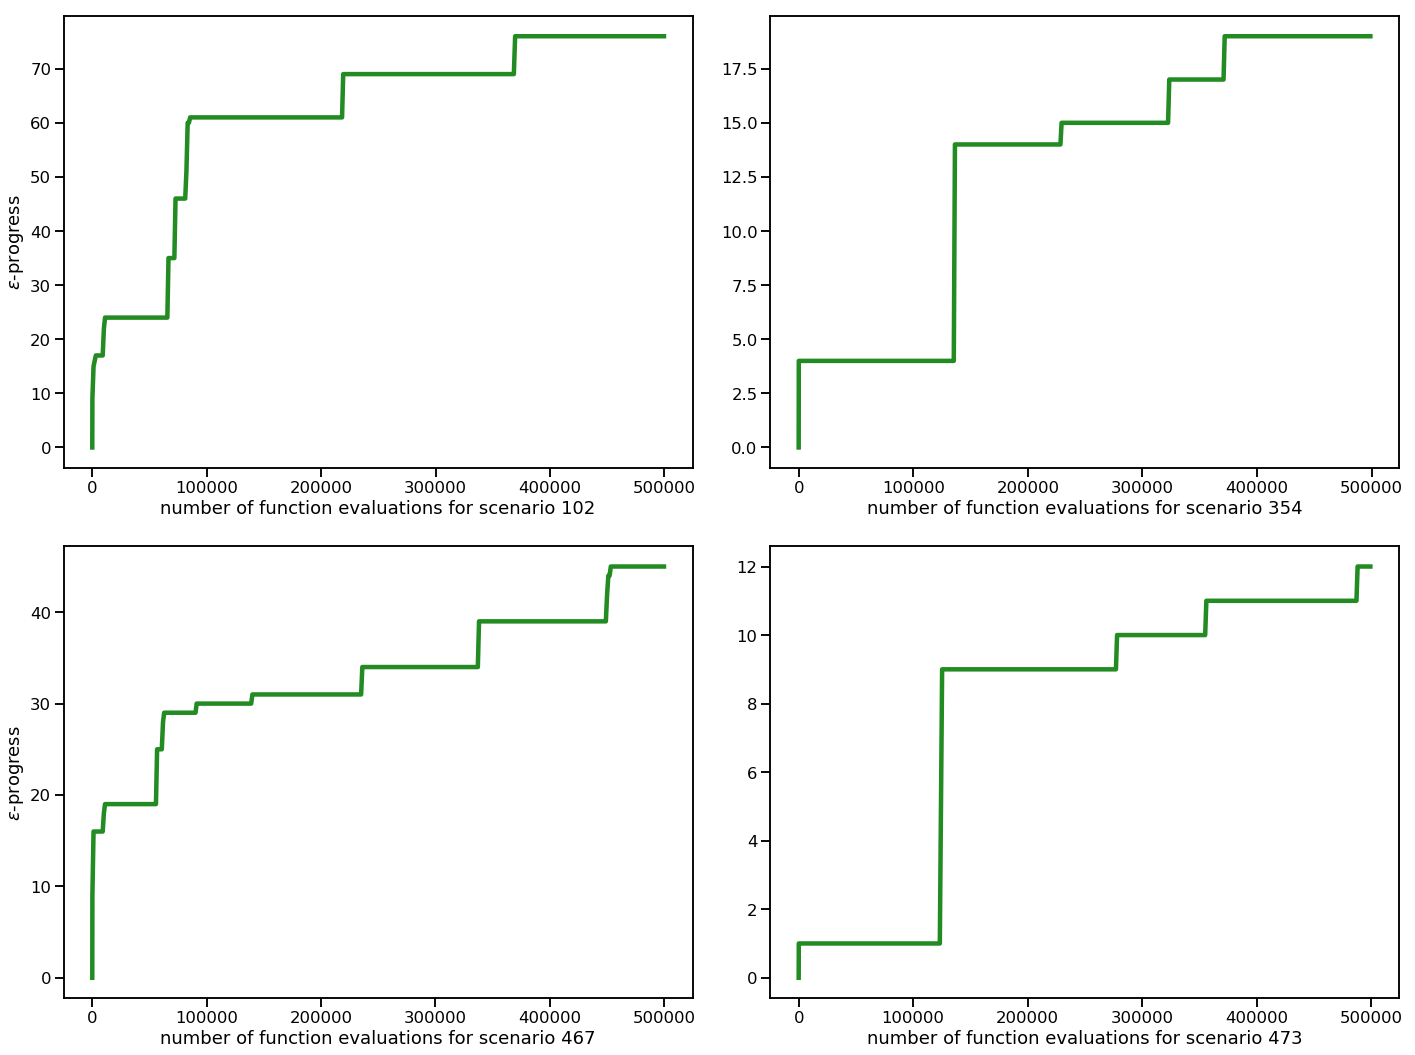

In [10]:
fig, axes = plt.subplots(ncols=2, nrows = 2, figsize=(20,15))
axes[0,0].plot(convergence_102.nfe, convergence_102.epsilon_progress, color = "forestgreen", linewidth = 4.5)
axes[0,0].set_ylabel('$\epsilon$-progress')
axes[0,0].set_xlabel('number of function evaluations for scenario 102')

axes[0,1].plot(convergence_354.nfe, convergence_354.epsilon_progress, color = "forestgreen", linewidth = 4.5)
axes[0,1].set_xlabel('number of function evaluations for scenario 354')

axes[1,0].plot(convergence_467.nfe, convergence_467.epsilon_progress, color = "forestgreen", linewidth = 4.5)
axes[1,0].set_ylabel('$\epsilon$-progress')
axes[1,0].set_xlabel('number of function evaluations for scenario 467')

axes[1,1].plot(convergence_473.nfe, convergence_473.epsilon_progress, color = "forestgreen", linewidth = 4.5)
axes[1,1].set_xlabel('number of function evaluations for scenario 473')

plt.tight_layout()
#fig.savefig("epsilon_convergence_MORDM_V4.png", bbox_inches='tight')
plt.show()

In [11]:
results_102["scenario"] = "scenario 102"
results_354["scenario"] = "scenario 354" 
results_467["scenario"] = "scenario 467" 
results_473["scenario"] = "scenario 473"

In [12]:
results = pd.concat([results_102, results_354, results_467, results_473], ignore_index=True)
results.head()

sr     irstp  periodfullpart  miu_period  \
0  0.262103  0.001813              29          13   
1  0.484353  0.011618              52          11   
2  0.209431  0.001544              54          11   
3  0.260357  0.001023              18          14   
4  0.158858  0.001009              23          14   

   Atmospheric Temperature 2050  Damages 2050  Total Output 2050  \
0                      2.553908      0.568313         197.663823   
1                      2.599317      0.825985         254.407020   
2                      2.482013      0.427398         179.658377   
3                      2.570295      0.591714         197.300564   
4                      2.506609      0.408036         161.099273   

   Atmospheric Temperature 2100  Damages 2100  Total Output 2100  ...  \
0                      3.831226     21.656822         486.598326  ...   
1                      3.571390     17.877310         645.484479  ...   
2                      3.454488     10.052809         454.440540  ...   
3                      3.995695     28.196342         476.924150  ...   
4                      3.855603     18.216976         392.143512  ...   

   Damages 2150  Total Output 2150  Atmospheric Temperature 2200  \
0     16.761779         968.978847                      1.876866   
1      3.009899        1290.425710                      0.020960   
2      6.102809         895.527788                      1.534066   
3     27.566910         949.156620                      2.222893   
4     24.014353         767.291269                      2.635183   

   Damages 2200  Total Output 2200  Atmospheric Temperature 2300  \
0      0.580189        1589.831460                           0.0   
1      0.016723        2071.760851                           0.0   
2      0.143805        1445.738452                           0.0   
3      1.782992        1581.987660                           0.0   
4      4.512699        1275.113927                           0.0   

   Damages 2300  Utility 2300  Total Output 2300      scenario  
0      0.024000  26106.551437        2976.965249  scenario 102  
1      0.023634   4360.322245        2931.549640  scenario 102  
2      0.023908  27329.160065        2965.532862  scenario 102  
3      0.024068  30071.139880        2985.392564  scenario 102  
4      0.023838  29711.960386        2956.890489  scenario 102  

[5 rows x 21 columns]

In [13]:
outcomes = results.iloc[:,4:]

outcomes = outcomes.reindex(sorted(outcomes.columns), axis=1)

experiments = results.iloc[:,:4]

C:\Users\Shajee\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


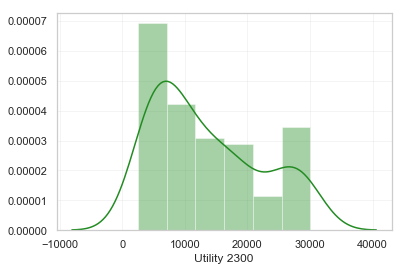

In [14]:
sns.set(context='notebook', style='whitegrid')
sns.distplot(outcomes.iloc[:,-2], color = "forestgreen")
plt.grid(alpha = 0.2)
plt.show()

In [15]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

viridis = cm.get_cmap('viridis', 12)
cmap = ListedColormap(sns.color_palette())   

In [16]:
sns.set_context("talk")

In [17]:
clr_palette = ([(0.66,0.66,0.66),sns.color_palette("inferno", 15)[-3],sns.color_palette("YlGn", 10)[-4],
                sns.color_palette("viridis", 10)[3],sns.cubehelix_palette(10)[5]])

In [18]:
results=results.rename(columns = {'sr':'Savings Rate', 'irstp':'Pure Rate of Social Time Preference', 'miu_period':'Emission Control Rate Target'})
resDF = results.copy()
resDF.index = resDF.scenario
resDF = resDF.iloc[:,[0,1,3]]

In [19]:
pollimits = pd.DataFrame({"Savings Rate":[0.1,0.5], 'Pure Rate of Social Time Preference':[0.001, 0.015], 'Emission Control Rate Target':[10, 58]})

C:\Users\Shajee\Anaconda3\lib\site-packages\matplotlib\tight_layout.py:198: UserWarning: tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes width small enough '


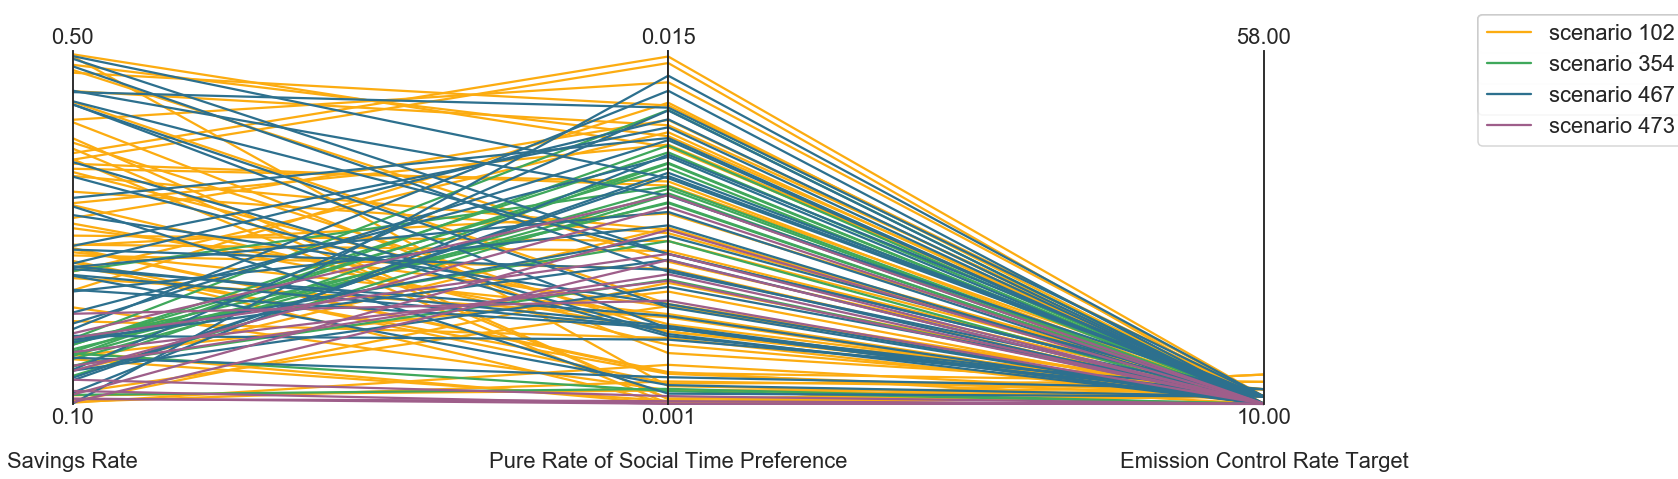

In [20]:
paraxes = parcoords.ParallelAxes(parcoords.get_limits(pollimits), rot=0, fontsize=22)
paraxes.fig.set_size_inches(20,7)
for j,k in enumerate(scenario_lst):
    paraxes.plot(resDF[resDF.index == "scenario " + str(k)],
                 color = clr_palette[j+1],
                 label = "scenario " + str(k)
                )
    paraxes.legend()
# cf.change_fontsize(paraxes, fs=24)
#paraxes.fig.savefig("plot_policies_V4.png", bbox_inches='tight')
plt.show()

C:\Users\Shajee\Anaconda3\lib\site-packages\matplotlib\tight_layout.py:198: UserWarning: tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes width small enough '


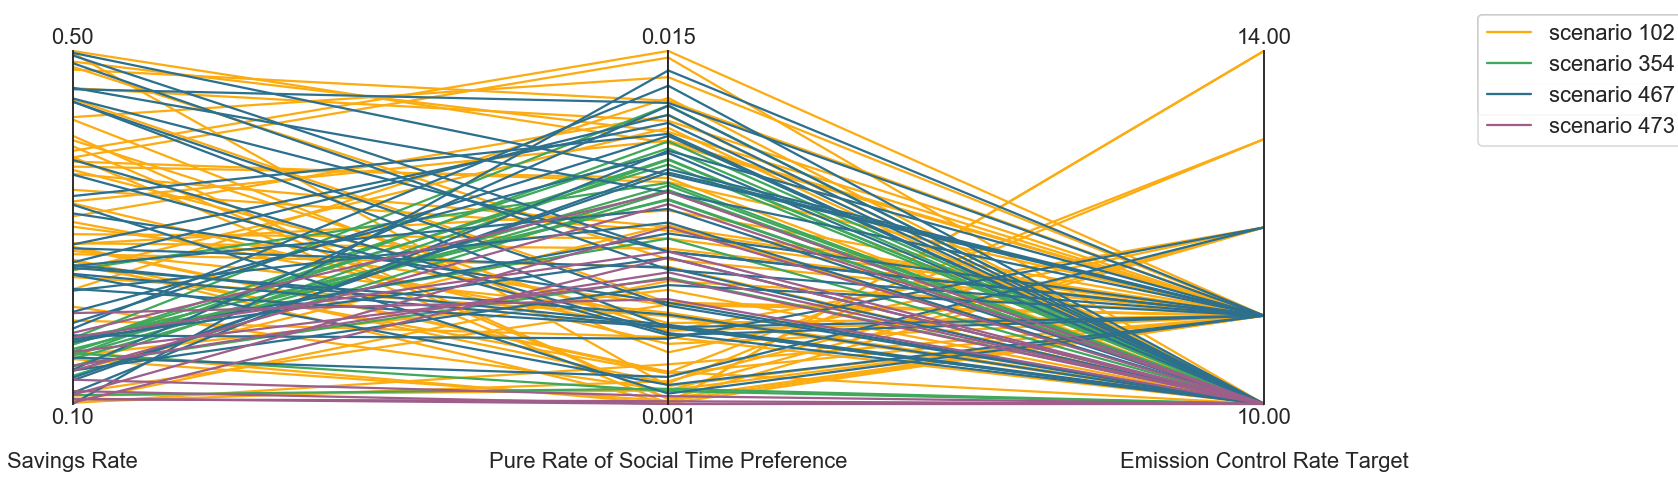

In [21]:
paraxes = parcoords.ParallelAxes(parcoords.get_limits(resDF), rot=0, fontsize=22)
paraxes.fig.set_size_inches(20,7)
for j,k in enumerate(scenario_lst):
    paraxes.plot(resDF[resDF.index == "scenario " + str(k)],
                 color = clr_palette[j+1],
                 label = "scenario " + str(k)
                )
    paraxes.legend()
#paraxes.fig.savefig("plot_policies_zoomin_V4.png", bbox_inches='tight')
plt.show()

C:\Users\Shajee\Anaconda3\lib\site-packages\matplotlib\tight_layout.py:198: UserWarning: tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes width small enough '


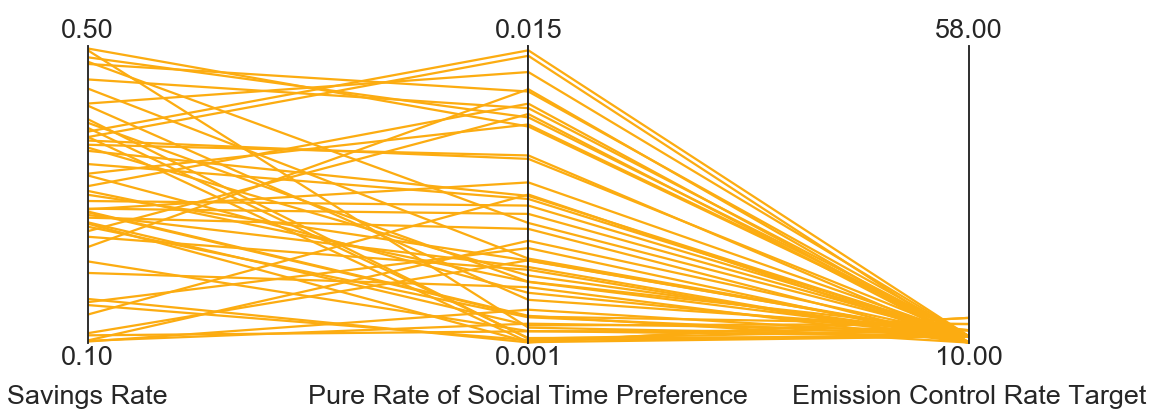

C:\Users\Shajee\Anaconda3\lib\site-packages\matplotlib\tight_layout.py:198: UserWarning: tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes width small enough '


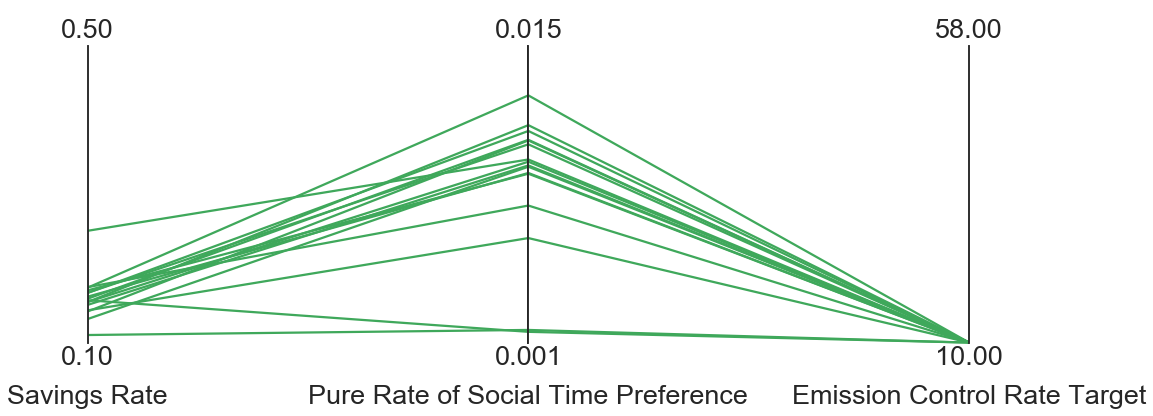

C:\Users\Shajee\Anaconda3\lib\site-packages\matplotlib\tight_layout.py:198: UserWarning: tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes width small enough '


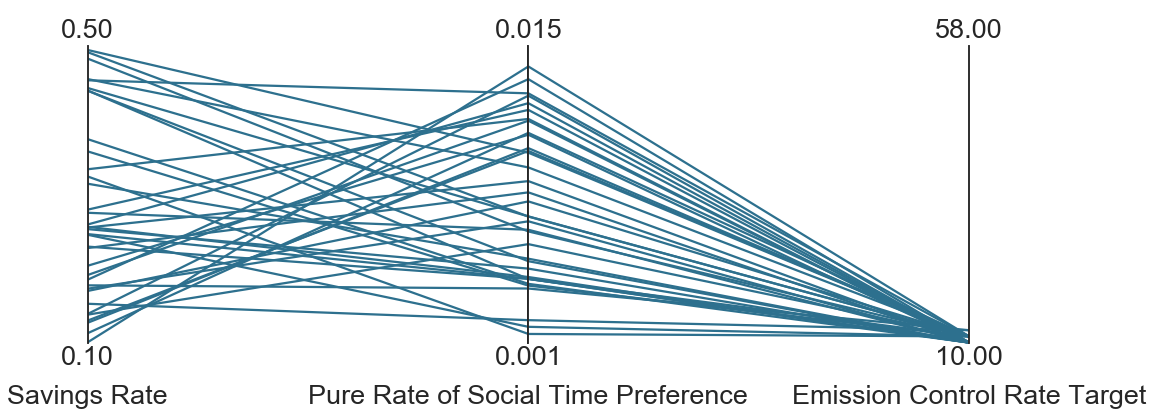

C:\Users\Shajee\Anaconda3\lib\site-packages\matplotlib\tight_layout.py:198: UserWarning: tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes width small enough '


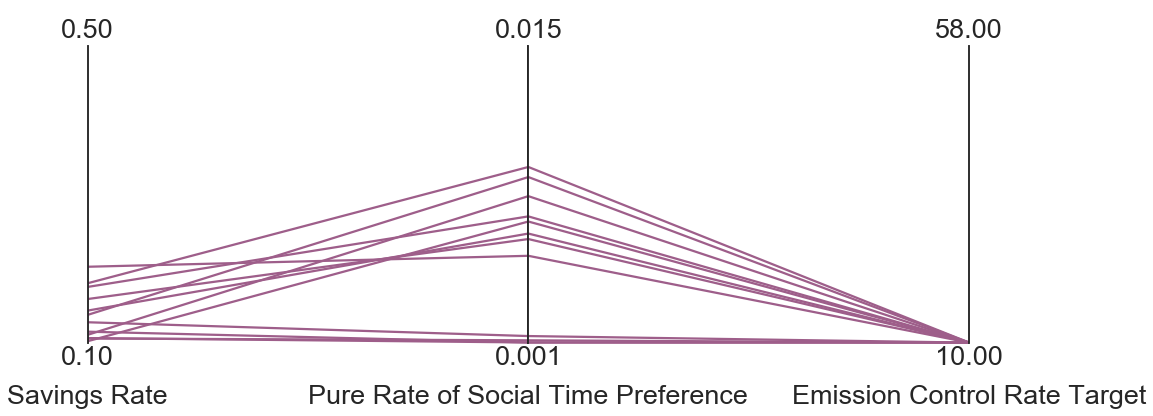

In [22]:
for i,j in enumerate(scenario_lst):
    paraxes = parcoords.ParallelAxes(parcoords.get_limits(pollimits), rot=0, fontsize=27)
    paraxes.fig.set_size_inches(39,7)
    paraxes.plot(results[results.scenario == "scenario " + str(j)].iloc[:,[0,1,3]], color = clr_palette[i+1])
    #paraxes.fig.savefig("plot_policies_scenario_" + str(j) + "_V4.png", bbox_inches='tight')
    plt.show()

In [23]:
resDF[resDF.index == "scenario 354"].describe()

Savings Rate  Pure Rate of Social Time Preference  \
count     16.000000                            16.000000   
mean       0.160531                             0.008662   
std        0.029271                             0.003170   
min        0.110217                             0.001508   
25%        0.148916                             0.008587   
50%        0.158081                             0.009441   
75%        0.167879                             0.010539   
max        0.250581                             0.012655   

       Emission Control Rate Target  
count                          16.0  
mean                           10.0  
std                             0.0  
min                            10.0  
25%                            10.0  
50%                            10.0  
75%                            10.0  
max                            10.0

In [24]:
resDF[resDF.index == "scenario 473"].describe()

Savings Rate  Pure Rate of Social Time Preference  \
count     12.000000                            12.000000   
mean       0.138507                             0.005099   
std        0.033691                             0.003171   
min        0.101816                             0.001005   
25%        0.109328                             0.001259   
50%        0.132363                             0.006011   
75%        0.162741                             0.007189   
max        0.202162                             0.009280   

       Emission Control Rate Target  
count                          12.0  
mean                           10.0  
std                             0.0  
min                            10.0  
25%                            10.0  
50%                            10.0  
75%                            10.0  
max                            10.0

In [25]:
# import plotly.plotly as py
# import plotly.graph_objs as go

# import pandas as pd 

# data = [
#     go.Parcoords(
#         line = dict(color = experiments["irstp"],
#                    colorscale = 'Jet',
#                    showscale = True,
#                    reversescale = False,
#                    cmin = experiments["irstp"].min(),
#                    cmax = experiments["irstp"].max()),
#         dimensions = list([
#             dict(range = [experiments["sr"].min(),experiments["sr"].max()],
#                  label = 'Savings Rate', values = experiments["sr"]),
#             dict(range = [experiments["irstp"].min(),experiments["irstp"].max()],
#                  label = 'Intitial rate of social time preference', values = experiments["irstp"]),
#             dict(range = [experiments["periodfullpart"].min(),experiments["periodfullpart"].max()],
#                  label = 'Time period at full participation', values = experiments["periodfullpart"]),
#             dict(range = [experiments["miu_period"].min(),experiments["miu_period"].max()],
#                  label = 'Time period until full control rate', values = experiments["miu_period"])
#         ])
#     )
# ]

# py.iplot(data, filename = 'parcoords-dice_sm')

In [26]:
policy_DF = results.iloc[:,[0,1,3,-1]]

C:\Users\Shajee\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shajee\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\Shajee\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\Shajee\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


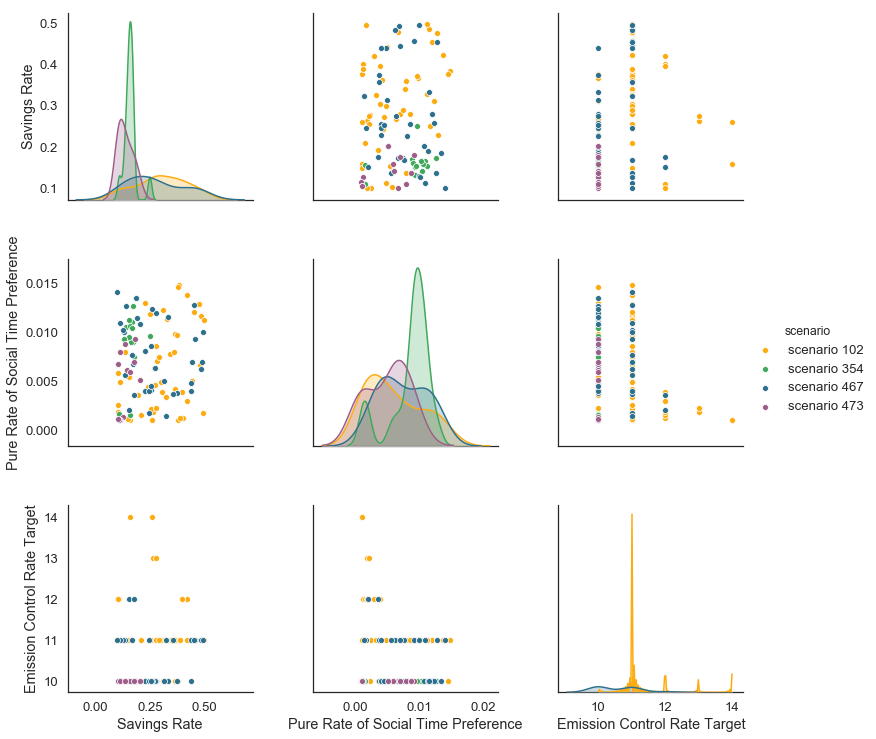

In [27]:
sns.set(font_scale=1.2, style = "white")
pplot_policy = sns.pairplot(data = policy_DF, hue = "scenario", height=3.5, palette=clr_palette[1:5], 
             diag_kind = 'kde')
#pplot_policy.savefig("policy_pairplot_V4.png")
plt.show()

C:\Users\Shajee\Anaconda3\lib\site-packages\matplotlib\tight_layout.py:198: UserWarning: tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes width small enough '


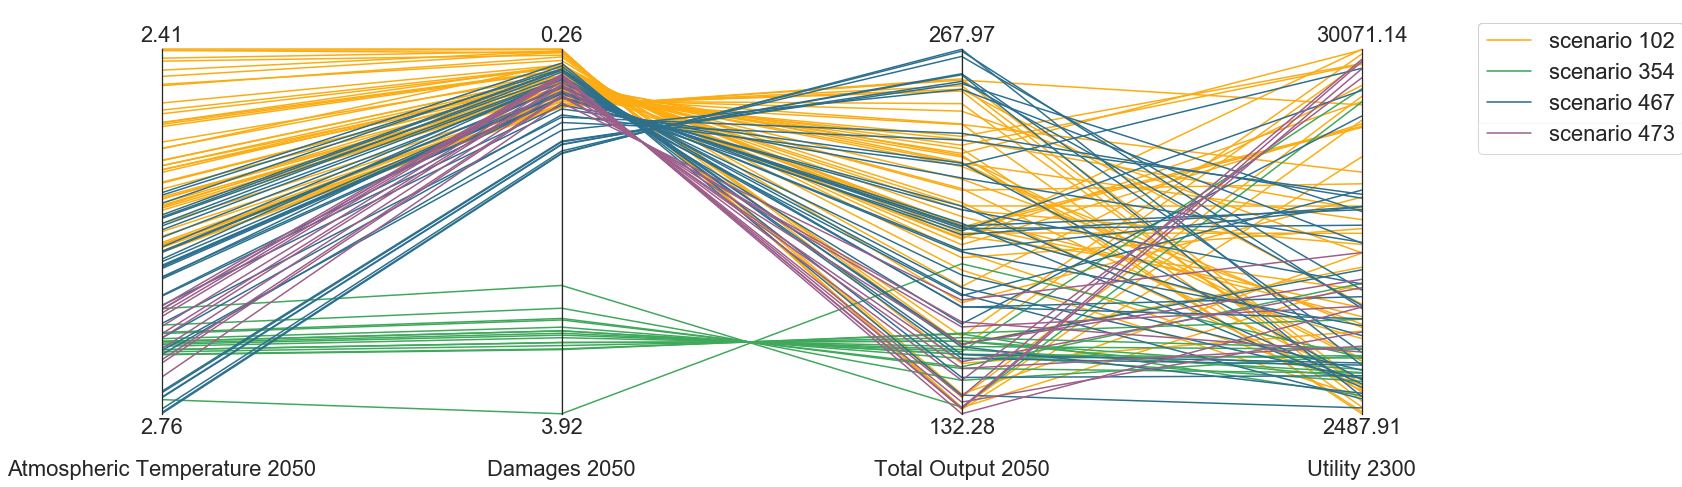

C:\Users\Shajee\Anaconda3\lib\site-packages\matplotlib\tight_layout.py:198: UserWarning: tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes width small enough '


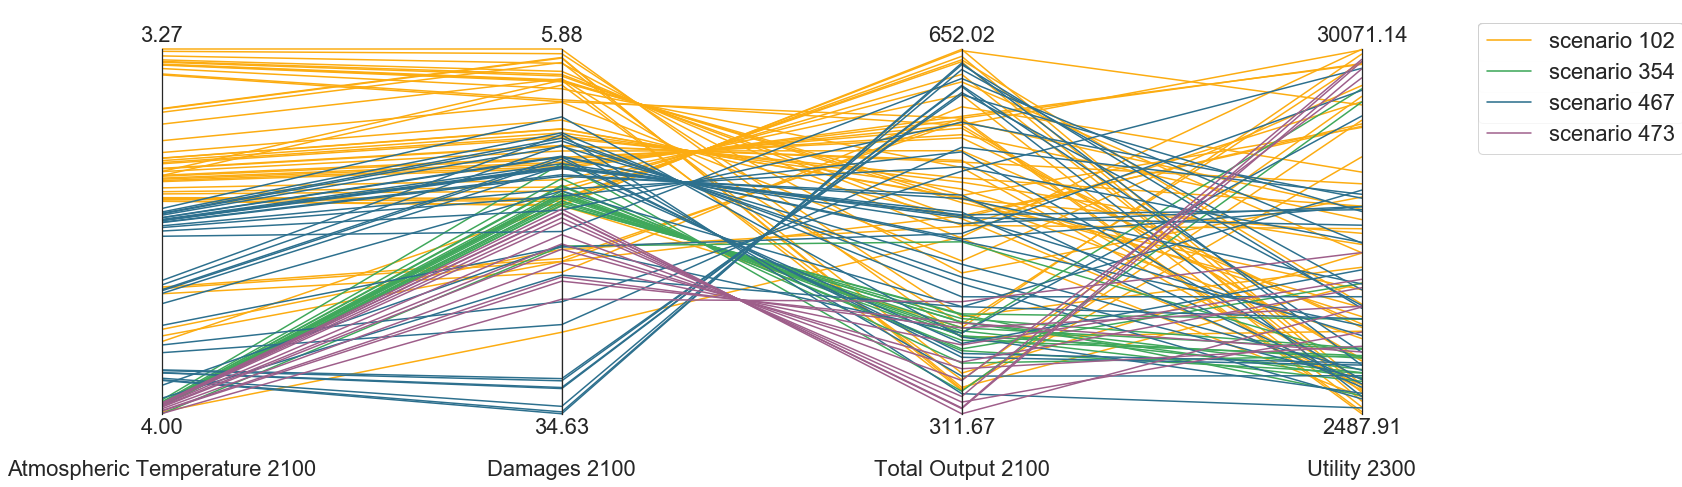

C:\Users\Shajee\Anaconda3\lib\site-packages\matplotlib\tight_layout.py:198: UserWarning: tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes width small enough '


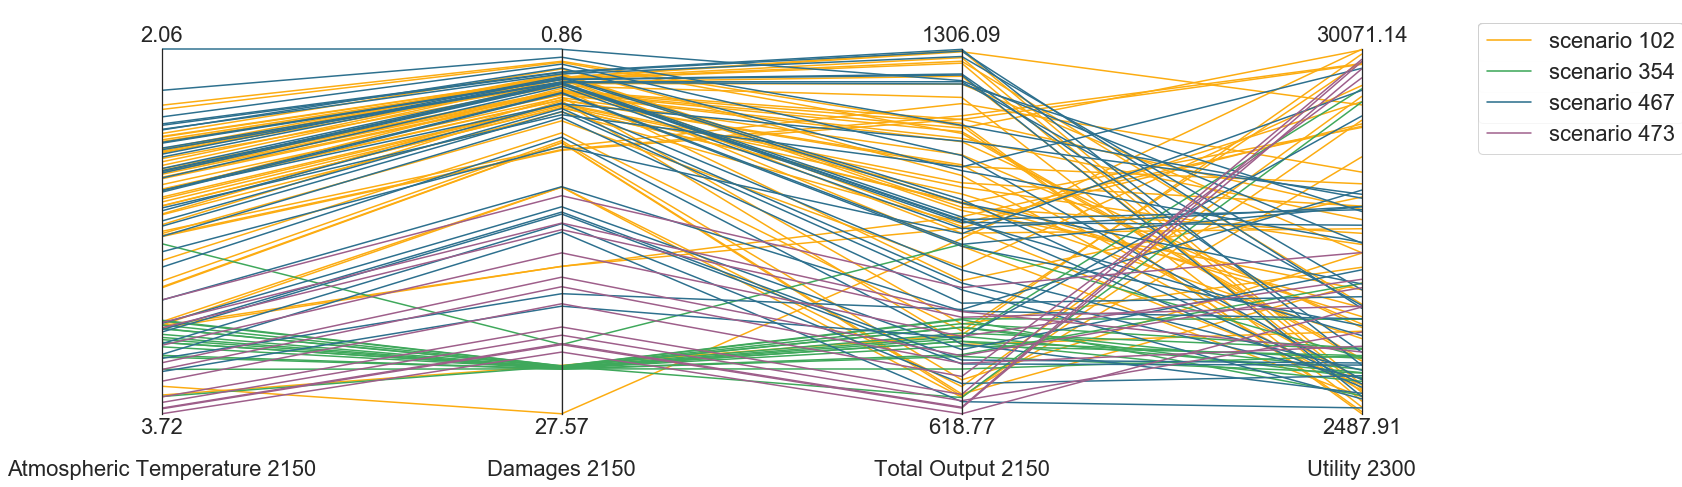

C:\Users\Shajee\Anaconda3\lib\site-packages\matplotlib\tight_layout.py:198: UserWarning: tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes width small enough '


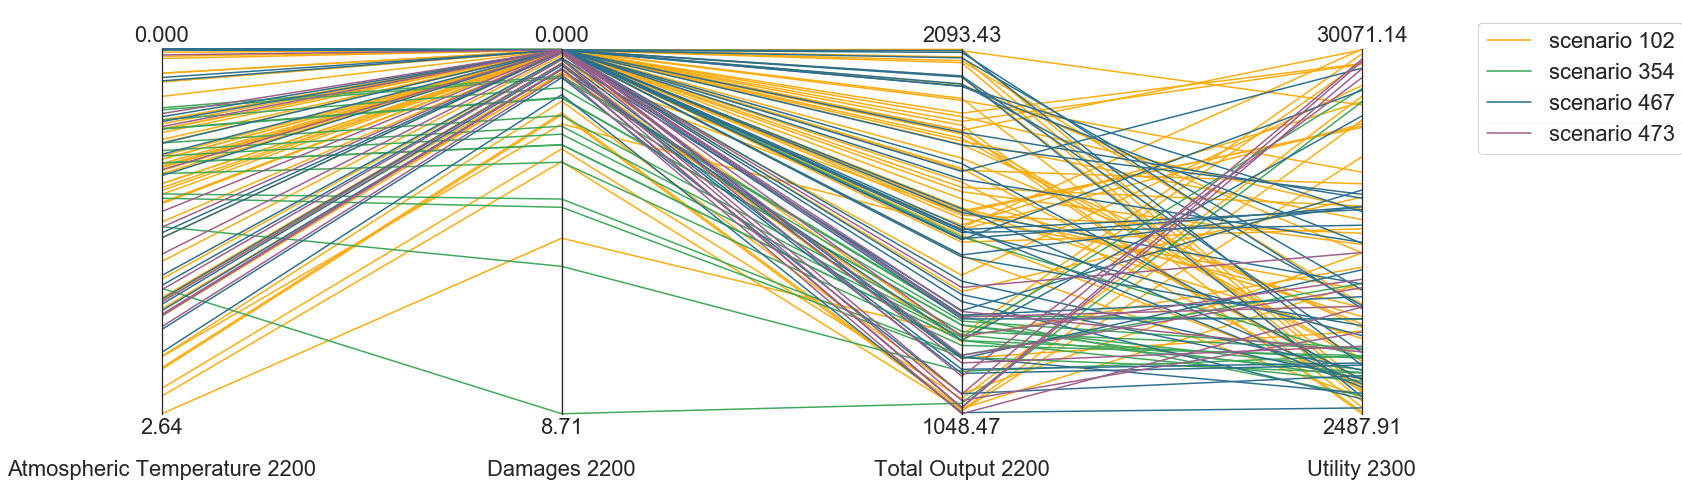

C:\Users\Shajee\Anaconda3\lib\site-packages\matplotlib\tight_layout.py:198: UserWarning: tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes width small enough '


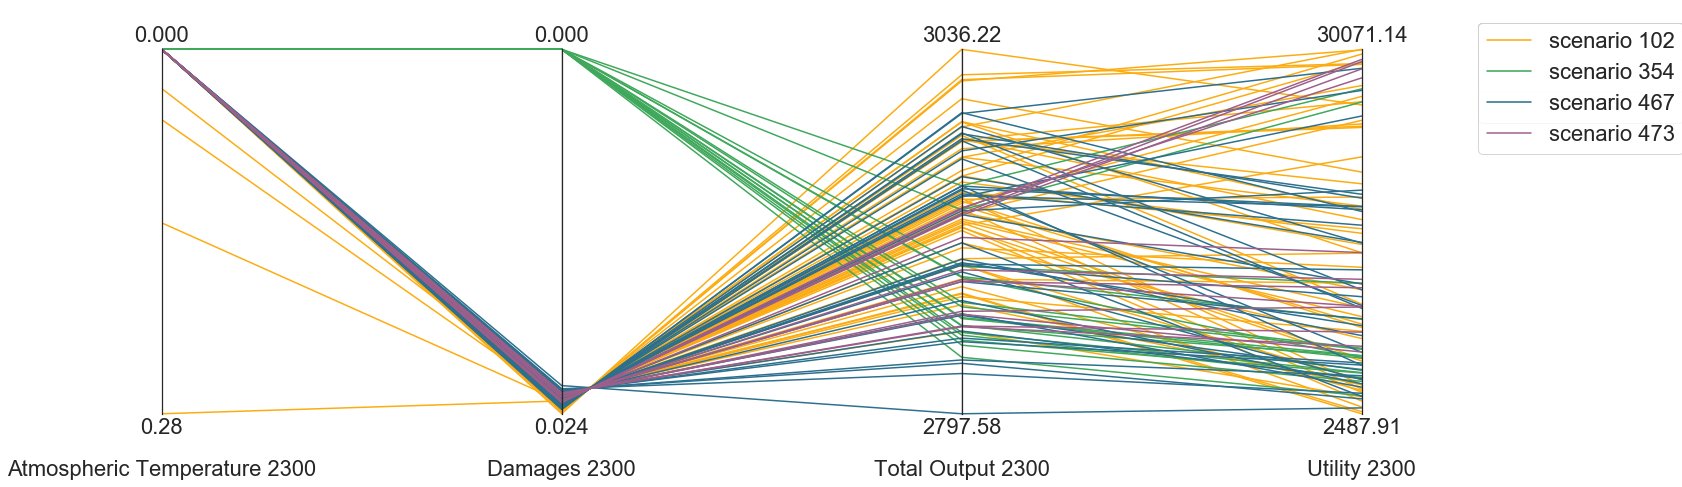

In [28]:
for i in range(int((len(outcomes.columns)-2)/3)):
    outcomes_columns = (list(outcomes.columns[i:-5+i:5]) + 
                          [np.array(outcomes.columns[-2]).tolist()]+[np.array(outcomes.columns[-1]).tolist()])
    outcomes_par = outcomes.loc[:,outcomes_columns]
    outcomes_par.index = outcomes_par.scenario
    del outcomes_par.index.name
    out_par = outcomes_par.iloc[:,:-1]
    paraxes = parcoords.ParallelAxes(parcoords.get_limits(out_par), rot=0, fontsize=22)
    paraxes.fig.set_size_inches(20,7)
    for j,k in enumerate(scenario_lst):
        paraxes.plot(out_par[out_par.index == "scenario " + str(k)],
                     color = clr_palette[j+1],
                     label = "scenario " + str(k)
                    )
        paraxes.legend()
    paraxes.invert_axis(outcomes_columns[0:2])
    #plt.gca().legend(('policy 0','policy 1','policy 2','policy 3'), bbox_to_anchor=(1.5, 1), fontsize = 15)
    plt.show()

# Evaluate the robustness of the policies

In [29]:
model = PyDICE()
dice_sm = Model('dicesmEMA', function = model)
dice_opt = pd.read_excel("DICE2013R.xlsm" ,sheet_name = "Opttax", index_col = 0)

In [30]:
dice_sm.uncertainties = [IntegerParameter('t2xco2_index', 0, 999),
                         IntegerParameter('t2xco2_dist',0 , 2),
                         IntegerParameter('fdamage', 0, 2),
                         RealParameter('tfp_gr', 0.07, 0.09),
                         RealParameter('sigma_gr', -0.012, -0.008),
                         RealParameter('pop_gr', 0.1, 0.15),
                         RealParameter('fosslim',  4000.0, 13649),
                         IntegerParameter('cback', 100, 600)]

dice_sm.levers = [RealParameter('sr', 0.1, 0.5),
                  RealParameter('irstp',  0.001, 0.015),
                  IntegerParameter('periodfullpart', 10, 58),
                  IntegerParameter('miu_period', 10, 58)]

dice_sm.outcomes = [ScalarOutcome('Atmospheric Temperature 2050', ScalarOutcome.MINIMIZE),
                    ScalarOutcome('Damages 2050', ScalarOutcome.MINIMIZE),
                    ScalarOutcome('Utility 2050', ScalarOutcome.INFO),
                    ScalarOutcome('Total Output 2050', ScalarOutcome.MAXIMIZE),
                    ScalarOutcome('Atmospheric Temperature 2100', ScalarOutcome.MINIMIZE),
                    ScalarOutcome('Damages 2100', ScalarOutcome.MINIMIZE),
                    ScalarOutcome('Utility 2100', ScalarOutcome.INFO),
                    ScalarOutcome('Total Output 2100', ScalarOutcome.MAXIMIZE),
                    ScalarOutcome('Atmospheric Temperature 2150', ScalarOutcome.MINIMIZE),
                    ScalarOutcome('Damages 2150', ScalarOutcome.MINIMIZE),
                    ScalarOutcome('Utility 2150', ScalarOutcome.INFO),
                    ScalarOutcome('Total Output 2150', ScalarOutcome.MAXIMIZE),
                    ScalarOutcome('Atmospheric Temperature 2200', ScalarOutcome.MINIMIZE),
                    ScalarOutcome('Damages 2200', ScalarOutcome.MINIMIZE),
                    ScalarOutcome('Utility 2200', ScalarOutcome.INFO),
                    ScalarOutcome('Total Output 2200', ScalarOutcome.MAXIMIZE),
                    ScalarOutcome('Atmospheric Temperature 2300', ScalarOutcome.MINIMIZE),
                    ScalarOutcome('Damages 2300', ScalarOutcome.MINIMIZE),
                    ScalarOutcome('Utility 2300', ScalarOutcome.MAXIMIZE),
                    ScalarOutcome('Total Output 2300', ScalarOutcome.MAXIMIZE)]

In [31]:
policies = results.iloc[:,:4]

In [32]:
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [33]:
# n_scenarios = 100000
# with MultiprocessingEvaluator(dice_sm, n_processes=8) as evaluator:
#     results = evaluator.perform_experiments(n_scenarios,
#                                             policies_to_evaluate)
# save_results(results, 'MORDM_explored_policy_100k_scen_113_pol.tar.gz')

In [34]:
results = load_results('MORDM_explored_policy_100k_scen_113_pol.tar.gz')

[MainProcess/INFO] results loaded succesfully from C:\Users\Shajee\Documents\GitHub\PyDICE\5_Policy_Discovery\MORDM_explored_policy_100k_scen_113_pol.tar.gz


In [35]:
experiments, outcomes = results

## Robustness Metrics

In [37]:
#import function and settings
from robustness_functions import *
clr_palette = sns.color_palette()

### Signal-To-Noise Ratio

In [38]:
snr_scores = s_to_n(experiments, outcomes, dice_sm.outcomes)

In [39]:
#create another copy
snr_scores_DF = snr_scores.copy()

#drop utility columns besides of 2300
snr_scores_DF = snr_scores_DF.drop(list(snr_scores_DF.columns[-5:-1]), axis = 1)

In [40]:
#normalizing the values between 0 and 1
#snr_scores_DF = snr_scores_DF/snr_scores_DF.max()

In [41]:
snr_scores_DF.iloc[:,:10] = (snr_scores_DF.iloc[:,:10].max() - snr_scores_DF.iloc[:,:10])/snr_scores_DF.iloc[:,:10].max()
snr_scores_DF.iloc[:,10:] = snr_scores_DF.iloc[:,10:]/snr_scores_DF.iloc[:,10:].max()

In [42]:
# for i in range(int(len(snr_scores_DF.columns)/5)):
#     stn_scores_columns = (list(snr_scores_DF.columns[i:-5+i:5]) + 
#                           [np.array(snr_scores_DF.columns[-1]).tolist()])
#     stn_scores_par = snr_scores_DF.loc[:,stn_scores_columns]
#     paraxes = parcoords.ParallelAxes(parcoords.get_limits(stn_scores_par), rot=0)
#     paraxes.fig.set_size_inches(20,7)
#     paraxes.plot(stn_scores_par)
#     #paraxes.invert_axis(stn_scores_columns[0:2])
#     paraxes.legend()
#     plt.show() 

In [43]:
# average snr
snr_scores_DF["Average SNR"] = (snr_scores_DF.iloc[:,:-1].sum(axis=1) + snr_scores_DF.iloc[:,[-1]].sum(axis = 1)*5)/(20)

In [44]:
snr_DF = snr_scores_DF.nlargest(10, "Average SNR")
snr_DF = snr_DF.sort_index()

In [45]:
#snr_DF = snr_scores_DF[stn_scores.iloc[:,-1] > stn_scores.iloc[:,-1].quantile(0.95)]

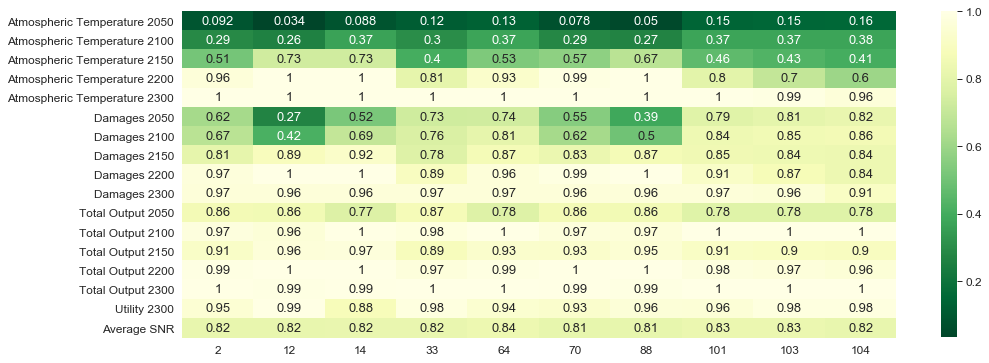

In [46]:
sns.set_context("paper", 1.35)
plt.figure(figsize=(16, 6))
sns.heatmap((snr_DF).T, cmap='YlGn_r', annot=True)
#plt.savefig("heatmap_snr_outcome_V4.png",bbox_inches ="tight")
plt.show()

C:\Users\Shajee\Anaconda3\lib\site-packages\matplotlib\tight_layout.py:198: UserWarning: tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes width small enough '


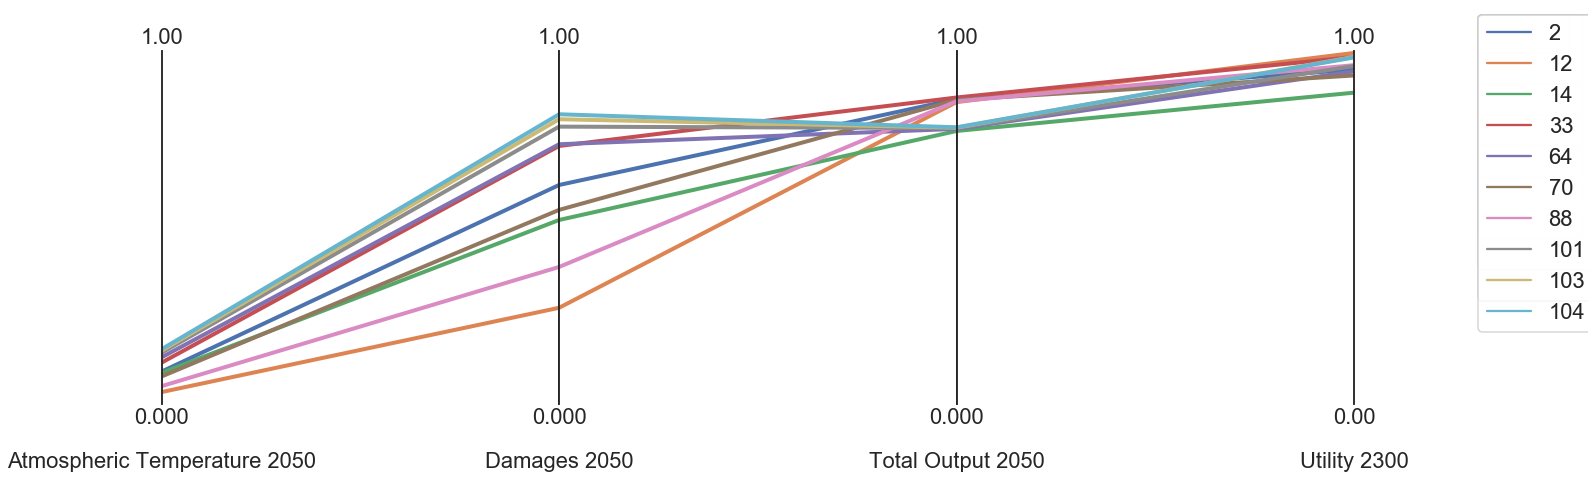

C:\Users\Shajee\Anaconda3\lib\site-packages\matplotlib\tight_layout.py:198: UserWarning: tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes width small enough '


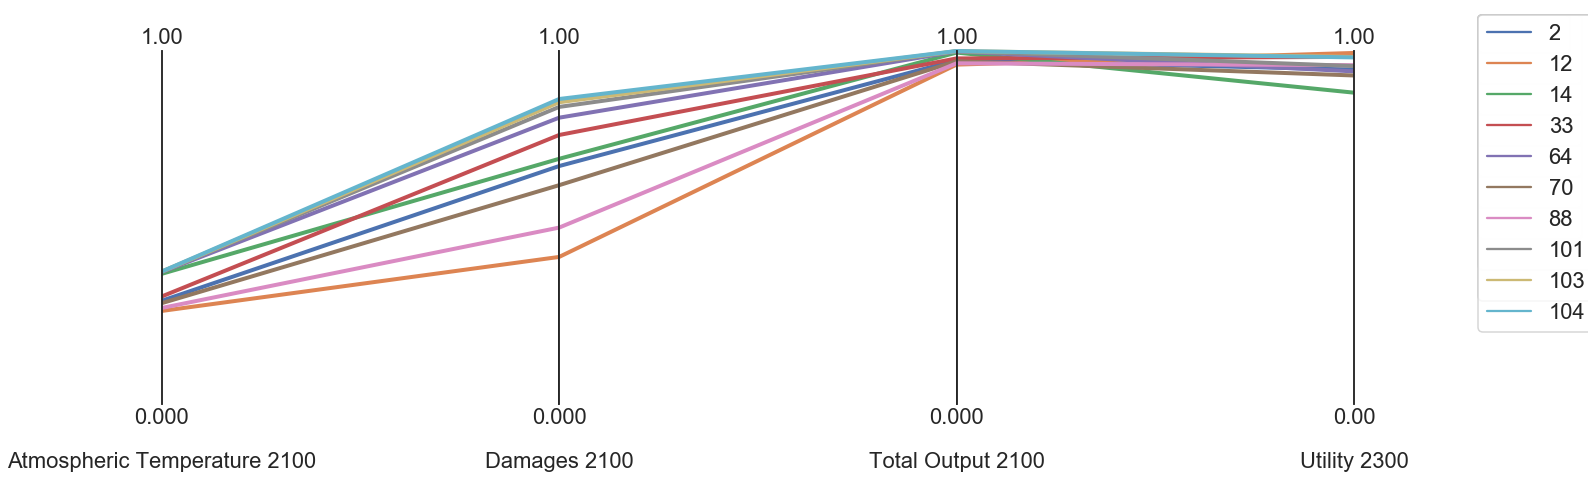

C:\Users\Shajee\Anaconda3\lib\site-packages\matplotlib\tight_layout.py:198: UserWarning: tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes width small enough '


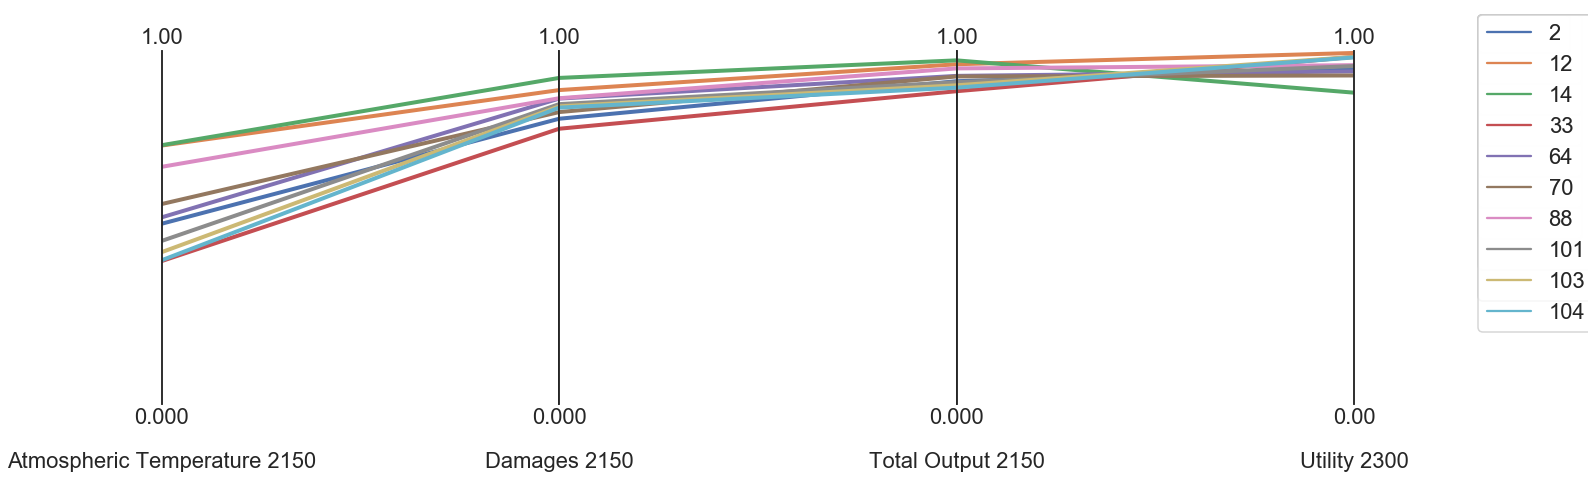

C:\Users\Shajee\Anaconda3\lib\site-packages\matplotlib\tight_layout.py:198: UserWarning: tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes width small enough '


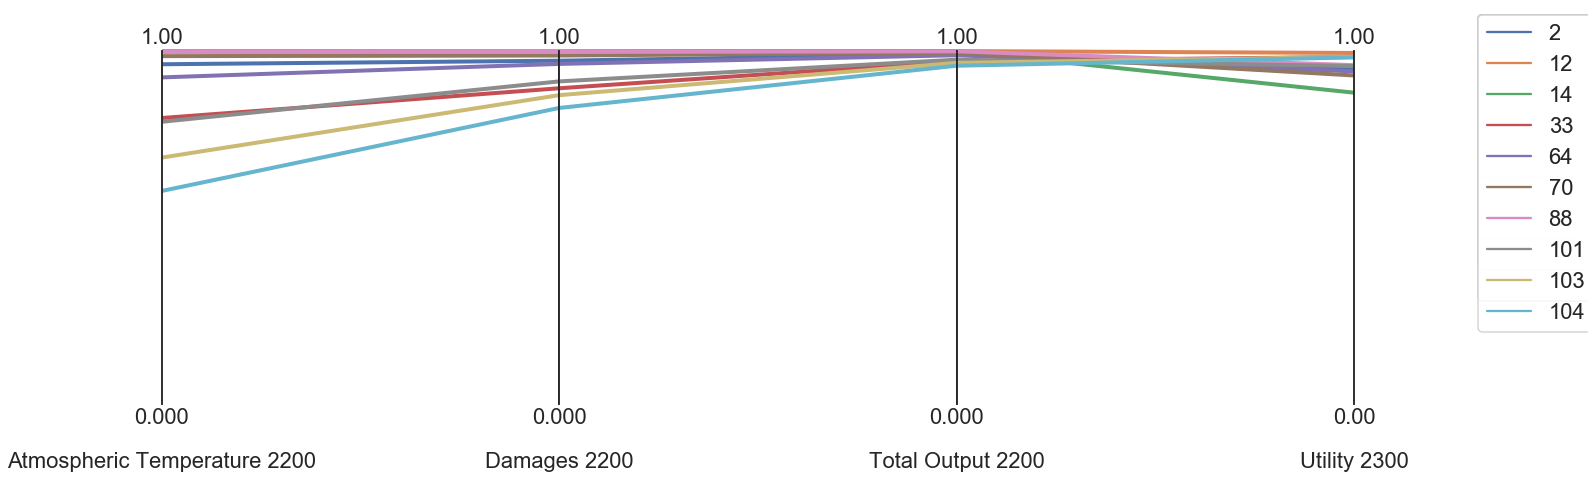

C:\Users\Shajee\Anaconda3\lib\site-packages\matplotlib\tight_layout.py:198: UserWarning: tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes width small enough '


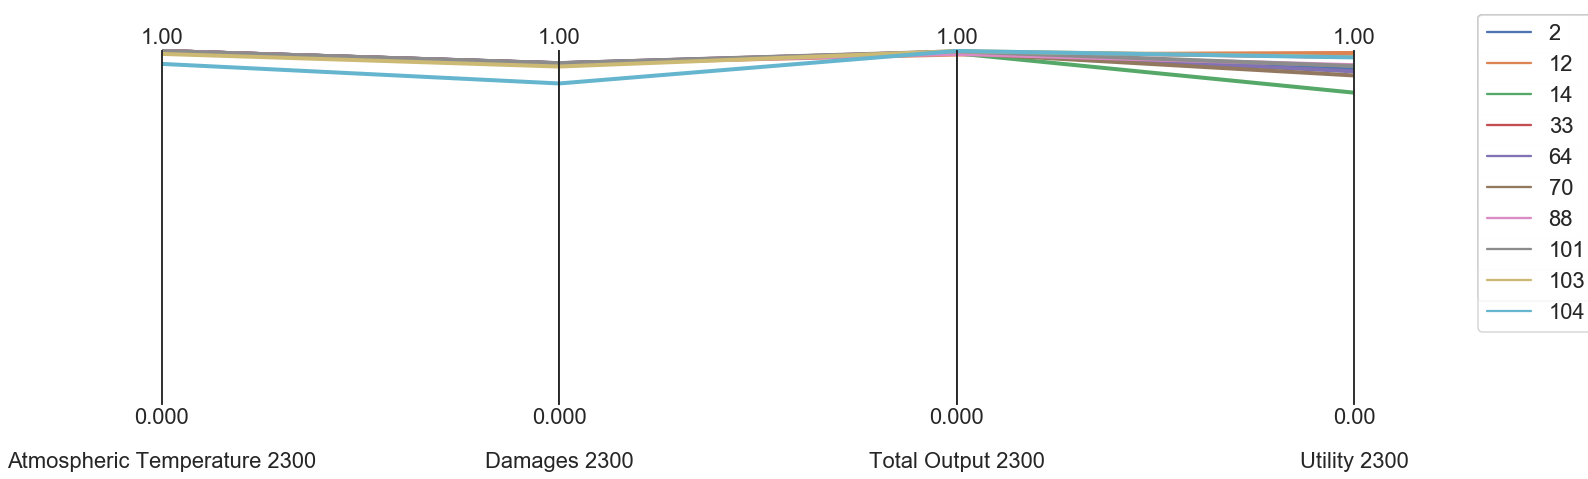

In [47]:
for i in range(int(len(snr_DF.columns)/4)+1):
    sns.set_context("talk")
    max_scores_columns = (list(snr_DF.columns[i:15:5]) + 
                          [np.array(snr_DF.columns[-2]).tolist()])
    max_scores_par = snr_DF.loc[:,max_scores_columns]
    max_scores_limits = pd.DataFrame(np.array([[0, 0, 0, 0],[1, 1, 1, 1]]), columns = max_scores_columns)
    paraxes = parcoords.ParallelAxes(parcoords.get_limits(max_scores_limits), rot=0, fontsize=22)
    paraxes.fig.set_size_inches(20,7)
    for j in range (int(len(max_scores_par.index.tolist()))):   
        paraxes.plot(max_scores_par.iloc[[j],:], 
                     linewidth=4,
                     color = clr_palette[j],
                     label = max_scores_par.index.tolist()[j])
        paraxes.legend()
    # paraxes.invert_axis(max_scores_columns)
    #paraxes.fig.savefig("snr_plot_"+snr_DF.columns[i][-4:]+".png", bbox_inches='tight')
    plt.show() 

In [48]:
snr_polDF = experiments[experiments.policy.
                       isin(list(snr_DF.index.values))].loc[:,['sr', 'irstp', 'periodfullpart', 'miu_period']].drop_duplicates()

snr_polDF.index = ((snr_polDF.index)/100000).astype(int)
snr_polDF.columns = ["Savings Rate","Pure Rate of Social Time Preference", "Full Participation Target", "Emission Control Rate Target"]

snr_polDF = snr_polDF.drop(["Full Participation Target"],axis=1)

In [49]:
pollimits = pd.DataFrame({"Savings Rate":[0.1,0.5], 'Pure Rate of Social Time Preference':[0.001, 0.015], 'Emission Control Rate Target':[10, 58]})

C:\Users\Shajee\Anaconda3\lib\site-packages\matplotlib\tight_layout.py:198: UserWarning: tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes width small enough '


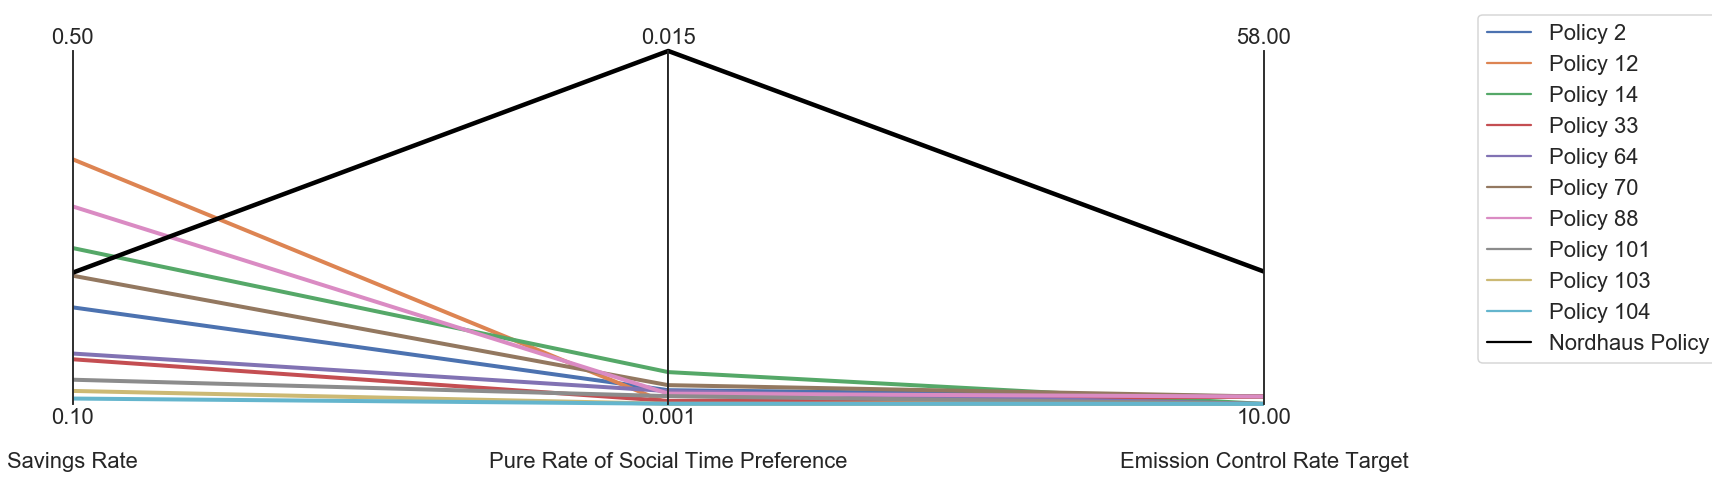

In [50]:
paraxes = parcoords.ParallelAxes(parcoords.get_limits(pollimits), rot=0, fontsize=22)
paraxes.fig.set_size_inches(20,7)
for i in range (len(snr_polDF)):
    paraxes.plot(snr_polDF.iloc[[i],:],
                 linewidth=4,
                 color = clr_palette[i],
                 label = ("Policy "+str(snr_polDF.index.tolist()[i])))
paraxes.plot(pd.DataFrame([np.mean(dice_opt.iloc[129]),0.015,28], index = snr_polDF.columns).T, 
             color = 'black',
             linewidth=4.5,
             label = 'Nordhaus Policy')
paraxes.legend()
#paraxes.fig.savefig("snr_plot_policies_V4.png", bbox_inches='tight')
plt.show() 

C:\Users\Shajee\Anaconda3\lib\site-packages\matplotlib\tight_layout.py:198: UserWarning: tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes width small enough '


<function matplotlib.pyplot.show(*args, **kw)>

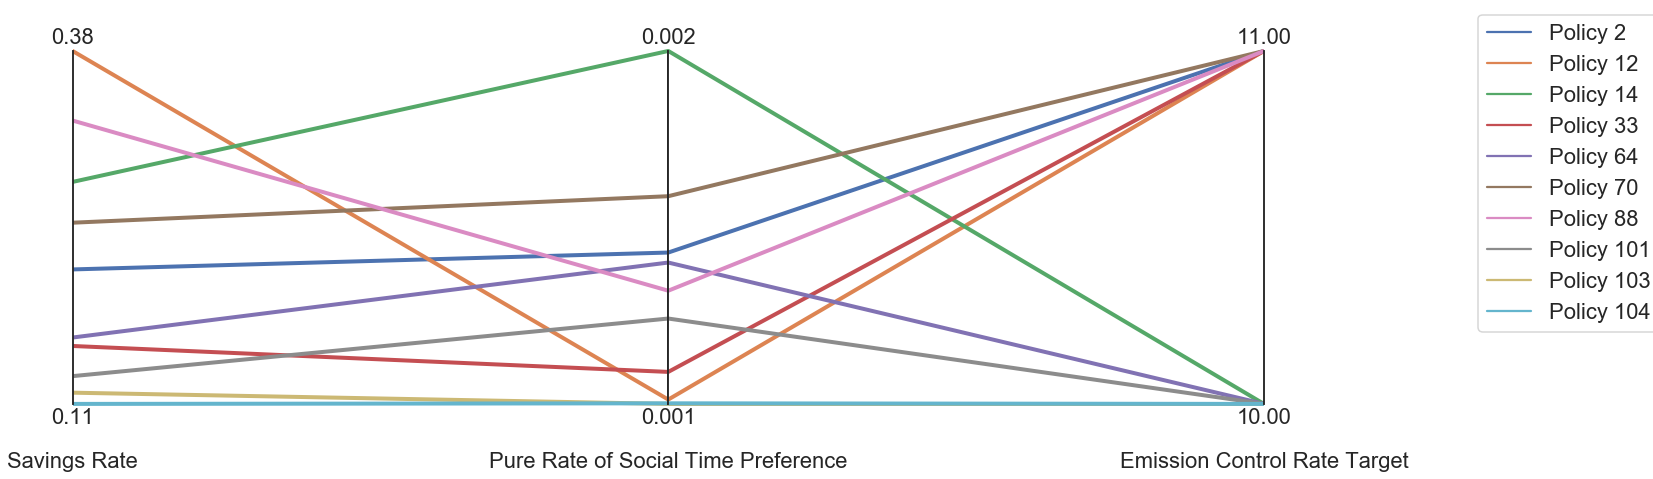

In [51]:
paraxes = parcoords.ParallelAxes(parcoords.get_limits(snr_polDF), rot=0, fontsize=22)
paraxes.fig.set_size_inches(20,7)
for i in range (len(snr_polDF)):
    paraxes.plot(snr_polDF.iloc[[i],:],
                 linewidth=4,
                 color = clr_palette[i],
                 label = ("Policy "+str(snr_polDF.index.tolist()[i])))
paraxes.legend()
#paraxes.fig.savefig("snr_regret_plot_policies_V4_wo_Nord.png", bbox_inches='tight')
plt.show

### Minimax regret

In [54]:
max_regret, overall_regret = max_regret(experiments, outcomes, dice_sm.outcomes)
# max_regret_w_util = max_regret.copy()

In [55]:
max_regret_DF = max_regret.copy()

In [56]:
#drop utility columns besides of 2300
max_regret_DF = max_regret_DF.drop(list(max_regret_DF.columns[2:-3:4]), axis = 1)

# normalisation of the maximum regret
max_regret_DF = max_regret_DF.reindex(sorted(max_regret_DF.columns), axis=1)
maxregretDF = (max_regret_DF/max_regret_DF.max())

# average maximum regret
#maxregretDF["average_max_regret"] = maxregretDF.mean(axis = 1)
maxregretDF["Average MiniMax Regret"] = (maxregretDF.iloc[:,:-1].sum(axis=1) + maxregretDF.iloc[:,[-1]].sum(axis = 1)*5)/(20)

In [57]:
maxregDF = maxregretDF.nsmallest(10, 'Average MiniMax Regret')
#maxregDF[maxregretDF.iloc[:,-1] < maxregretDF.iloc[:,-1].quantile(0.10)]

In [58]:
maxregDF = maxregDF.sort_index()

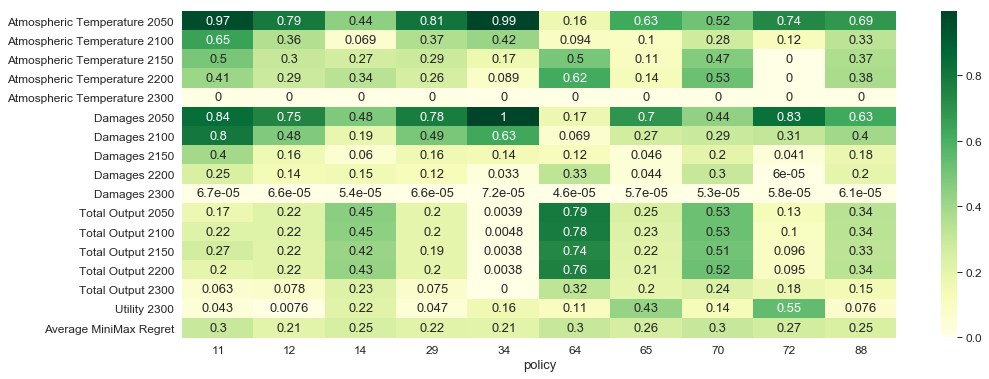

In [59]:
sns.set(context = "paper", font_scale = 1.35)
plt.figure(figsize=(16, 6))
hmp_maxreg = sns.heatmap((maxregDF).T, cmap='YlGn', annot=True)
#plt.savefig("heatmap_max_regret_outcome_V4.png",bbox_inches ="tight")
plt.show()

In [60]:
max_reg_wo_avgDF = maxregDF.drop(["Average MiniMax Regret"], axis = 1)

In [61]:
max_reg_wo_avgDF = max_reg_wo_avgDF.sort_index(axis=1)

In [62]:
len(max_reg_wo_avgDF.columns)/4

4.0

C:\Users\Shajee\Anaconda3\lib\site-packages\matplotlib\tight_layout.py:198: UserWarning: tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes width small enough '


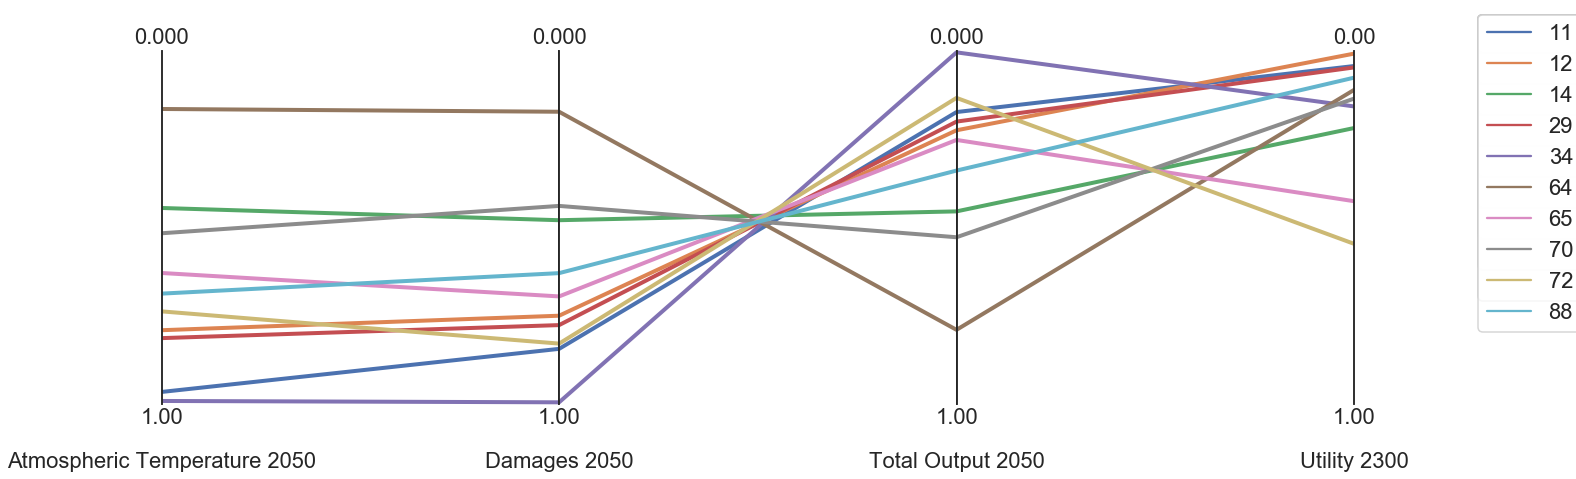

C:\Users\Shajee\Anaconda3\lib\site-packages\matplotlib\tight_layout.py:198: UserWarning: tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes width small enough '


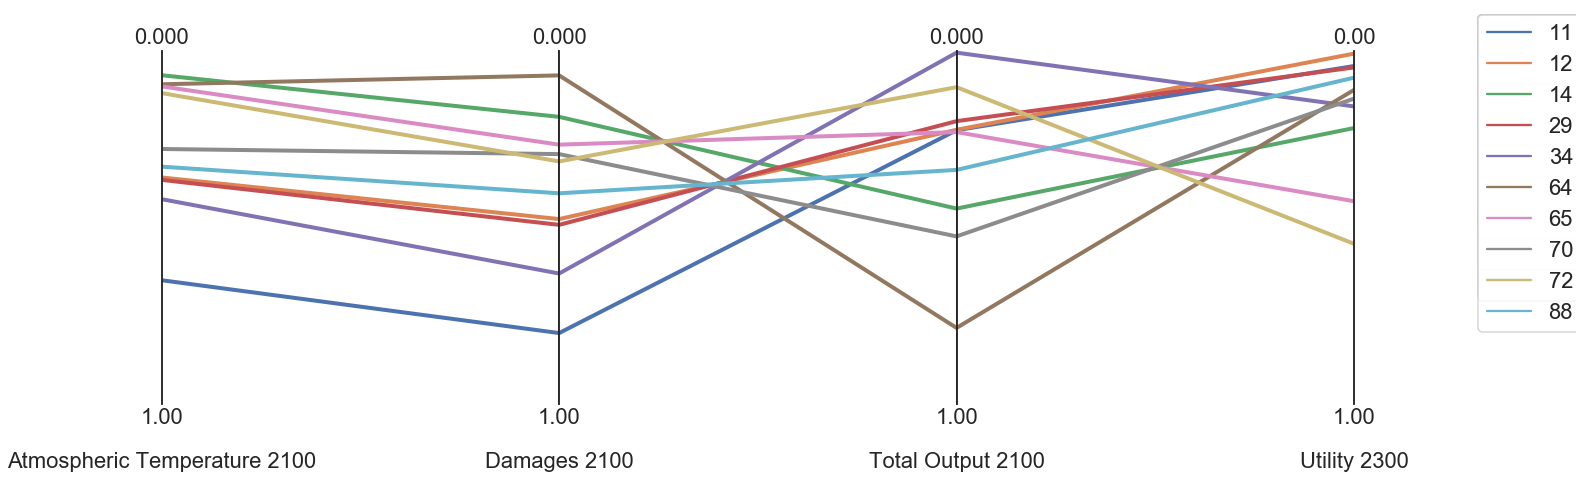

C:\Users\Shajee\Anaconda3\lib\site-packages\matplotlib\tight_layout.py:198: UserWarning: tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes width small enough '


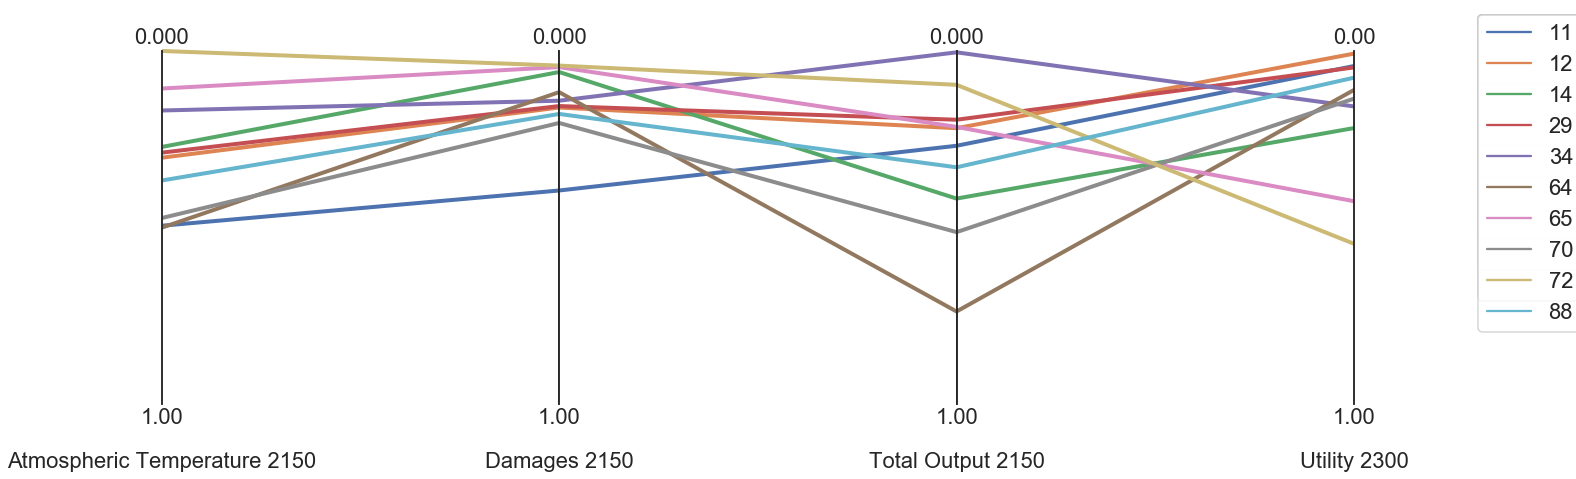

C:\Users\Shajee\Anaconda3\lib\site-packages\matplotlib\tight_layout.py:198: UserWarning: tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes width small enough '


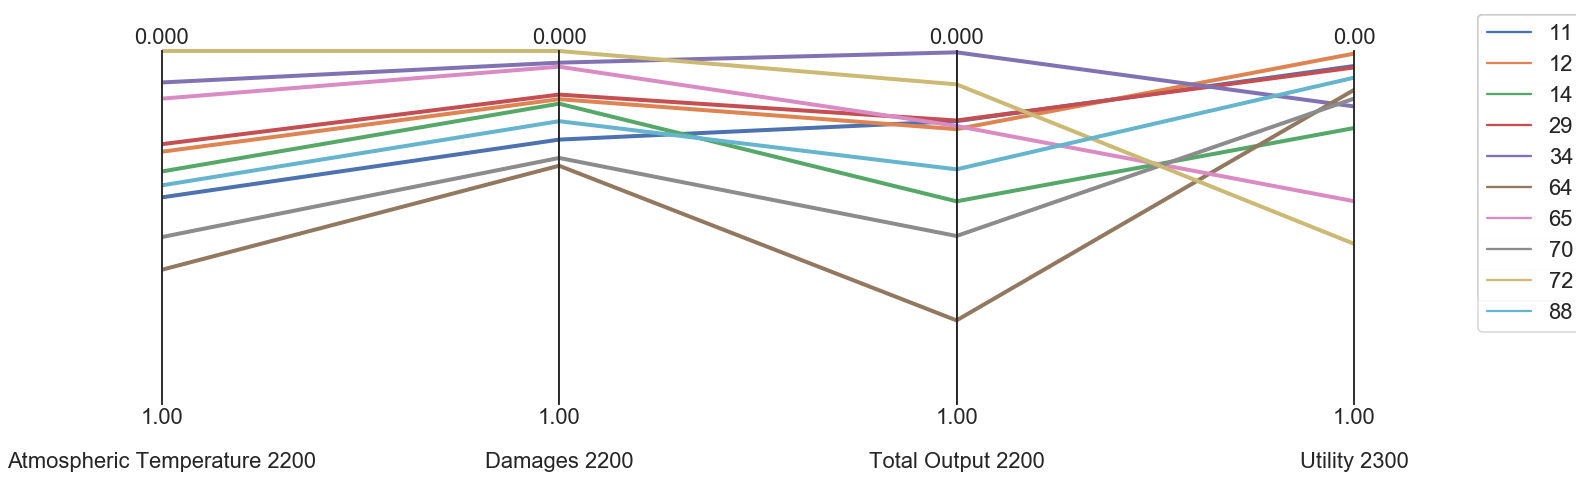

C:\Users\Shajee\Anaconda3\lib\site-packages\matplotlib\tight_layout.py:198: UserWarning: tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes width small enough '


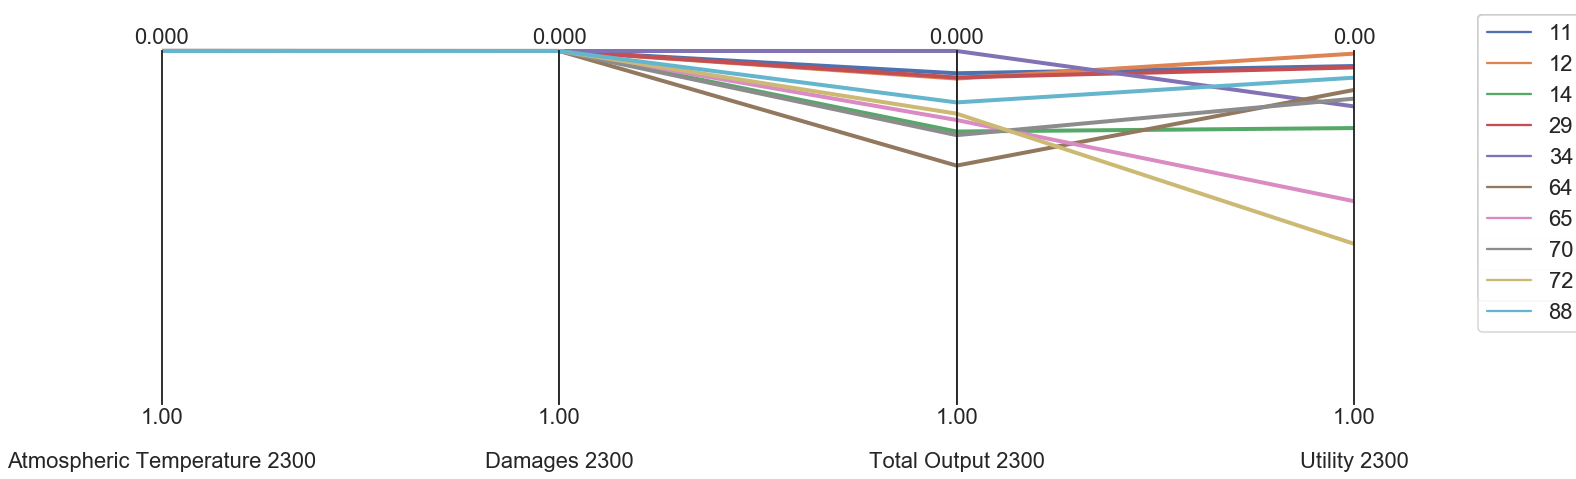

In [63]:
for i in range(int(len(max_reg_wo_avgDF.columns)/4)+1):
    sns.set_context("talk")
    max_scores_columns = (list(max_reg_wo_avgDF.columns[i:15:5]) + 
                          [np.array(max_reg_wo_avgDF.columns[-1]).tolist()])
    max_scores_par = max_reg_wo_avgDF.loc[:,max_scores_columns]
    max_scores_limits = pd.DataFrame(np.array([[0, 0, 0, 0],[1, 1, 1, 1]]), columns = max_scores_columns)
    paraxes = parcoords.ParallelAxes(parcoords.get_limits(max_scores_limits), rot=0, fontsize=22)
    paraxes.fig.set_size_inches(20,7)
    for j in range (int(len(max_scores_par.index.tolist()))):   
        paraxes.plot(max_scores_par.iloc[[j],:], 
                     linewidth=4,
                     color = clr_palette[j],
                     label = max_scores_par.index.tolist()[j])
        paraxes.legend()
    paraxes.invert_axis(max_scores_columns)
    #paraxes.fig.savefig("max_regret_plot_"+max_reg_wo_avgDF.columns[i][-4:]+".png", bbox_inches='tight')
    plt.show() 

In [64]:
robpolDF = experiments[experiments.policy.
                       isin(list(maxregDF.index.values))].loc[:,['sr', 'irstp', 'periodfullpart', 'miu_period']].drop_duplicates()

In [65]:
robpolDF = robpolDF.reset_index(drop=True)

In [66]:
robpolDF.columns = ["Savings Rate","Pure Rate of Social Time Preference", "Full Participation Target", "Emission Control Rate Target"]

In [67]:
# robpolDF_columns=["sr","irstp", "miu_period", "periodfullpart"]
# robpolDF=robpolDF.reindex(columns=robpolDF_columns)

In [68]:
robpolDF = robpolDF.drop(["Full Participation Target"],axis=1)

In [69]:
robpolDF = robpolDF.set_index(pd.Index(max_scores_par.index.tolist()))

In [70]:
robpolDF

Savings Rate  Pure Rate of Social Time Preference  \
11      0.401193                             0.001188   
12      0.377313                             0.001020   
14      0.276679                             0.002262   
29      0.389462                             0.001215   
34      0.494000                             0.001705   
64      0.157100                             0.001508   
65      0.374155                             0.003770   
70      0.245337                             0.001744   
72      0.439394                             0.004838   
88      0.323865                             0.001408   

    Emission Control Rate Target  
11                          12.0  
12                          11.0  
14                          10.0  
29                          11.0  
34                          11.0  
64                          10.0  
65                          10.0  
70                          11.0  
72                          10.0  
88                          11.0

In [71]:
pollimits = pd.DataFrame({"Savings Rate":[0.1,0.5], 'Pure Rate of Social Time Preference':[0.001, 0.015], 'Emission Control Rate Target':[10, 58]})

C:\Users\Shajee\Anaconda3\lib\site-packages\matplotlib\tight_layout.py:198: UserWarning: tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes width small enough '


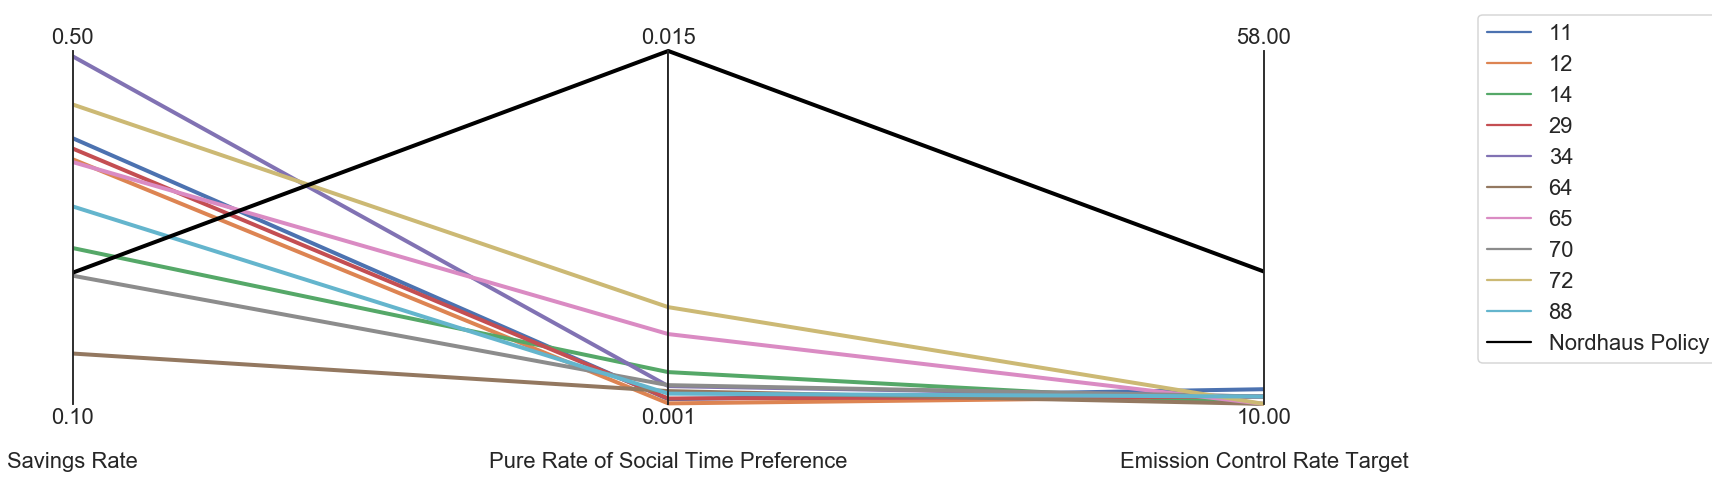

In [72]:
paraxes = parcoords.ParallelAxes(parcoords.get_limits(pollimits), rot=0, fontsize=22)
paraxes.fig.set_size_inches(20,7)
for j in range (int(len(robpolDF.index.tolist()))):   
    paraxes.plot(robpolDF.iloc[[j],:], 
                 linewidth=4,
                 color = clr_palette[j],
                 label = robpolDF.index.tolist()[j])
paraxes.plot(pd.DataFrame([np.mean(dice_opt.iloc[129]),0.015,28], index = robpolDF.columns).T, 
             color = 'black',
             linewidth=4,
             label = 'Nordhaus Policy')
#plt.gca().legend(bbox_to_anchor=(1.4, 1), fontsize = 15)
#paraxes.invert_axis(stn_scores_columns)
paraxes.legend()
#paraxes.fig.savefig("max_regret_plot_policies_V4.png", bbox_inches='tight')
plt.show() 

C:\Users\Shajee\Anaconda3\lib\site-packages\matplotlib\tight_layout.py:198: UserWarning: tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes width small enough '


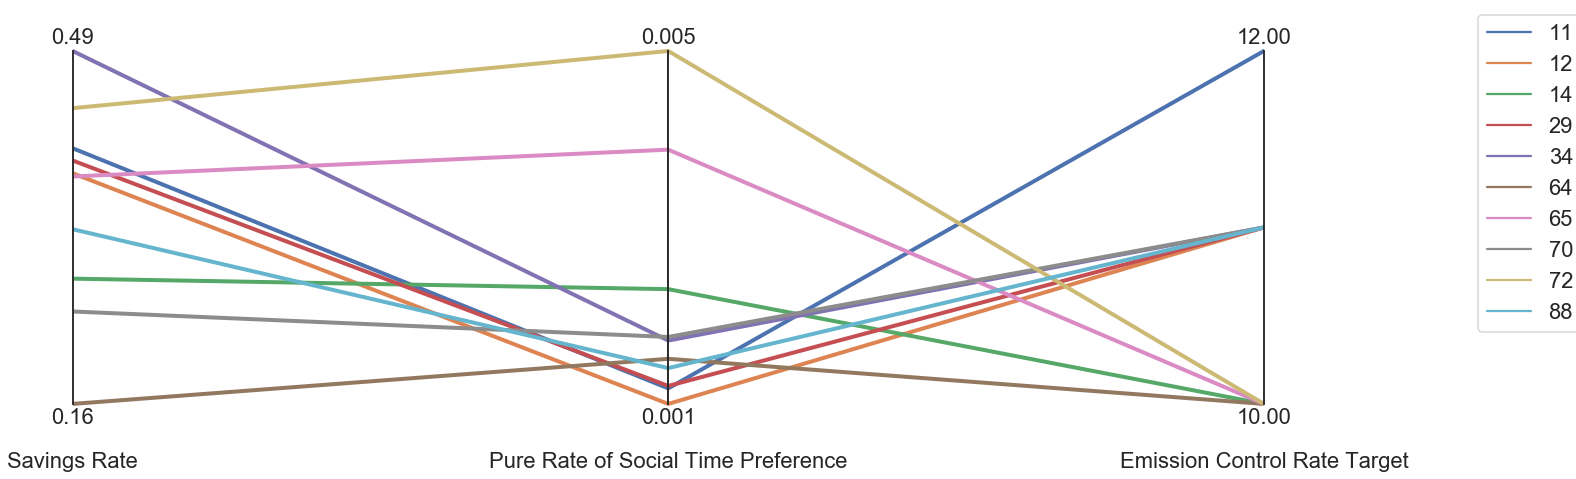

In [73]:
paraxes = parcoords.ParallelAxes(parcoords.get_limits(robpolDF), rot=0, fontsize=22)
paraxes.fig.set_size_inches(20,7)
for j in range (int(len(robpolDF.index.tolist()))):   
    paraxes.plot(robpolDF.iloc[[j],:], 
                 linewidth=4,
                 color = clr_palette[j],
                 label = robpolDF.index.tolist()[j])
# paraxes.plot(pd.DataFrame([np.mean(dice_opt.iloc[129]),0.015,28], index = robpolDF.columns).T, 
#              color = 'black',
#              linewidth=4,
#              label = 'Nordhaus Policy')
#plt.gca().legend(bbox_to_anchor=(1.4, 1), fontsize = 15)
#paraxes.invert_axis(stn_scores_columns)
paraxes.legend()
#paraxes.fig.savefig("max_regret_plot_policies_V4_wo_Nord.png", bbox_inches='tight')
plt.show() 

C:\Users\Shajee\Anaconda3\lib\site-packages\matplotlib\tight_layout.py:198: UserWarning: tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes width small enough '


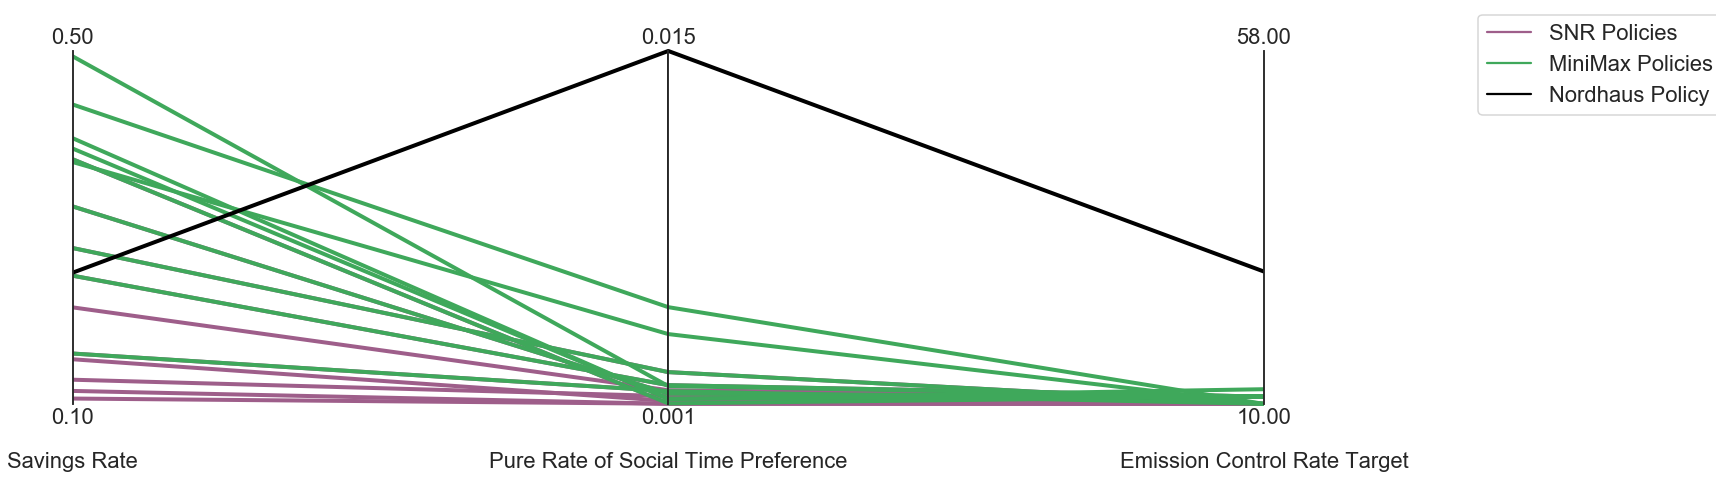

In [89]:
clr_palette = ([(0.66,0.66,0.66),sns.color_palette("inferno", 15)[-3],sns.color_palette("YlGn", 10)[-4],
                sns.color_palette("viridis", 10)[3],sns.cubehelix_palette(10)[5]])

paraxes = parcoords.ParallelAxes(parcoords.get_limits(pollimits), rot=0, fontsize=22)
paraxes.fig.set_size_inches(20,7)

paraxes.plot(snr_polDF, 
                 linewidth=4,
                 color = clr_palette[4],
                 label = "SNR Policies")
paraxes.plot(robpolDF, 
                 linewidth=4,
                 color = clr_palette[2],
                 label = "MiniMax Policies")
paraxes.plot(pd.DataFrame([np.mean(dice_opt.iloc[129]),0.015,28], index = robpolDF.columns).T, 
             color = 'black',
             linewidth=4,
             label = 'Nordhaus Policy')

             # paraxes.plot(pd.DataFrame([np.mean(dice_opt.iloc[129]),0.015,28], index = robpolDF.columns).T, 
#              color = 'black',
#              linewidth=4,
#              label = 'Nordhaus Policy')
#plt.gca().legend(bbox_to_anchor=(1.4, 1), fontsize = 15)
#paraxes.invert_axis(stn_scores_columns)
paraxes.legend()
paraxes.fig.savefig("combined_plot_policies_V4.png", bbox_inches='tight')
plt.show() 

C:\Users\Shajee\Anaconda3\lib\site-packages\matplotlib\tight_layout.py:198: UserWarning: tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes width small enough '


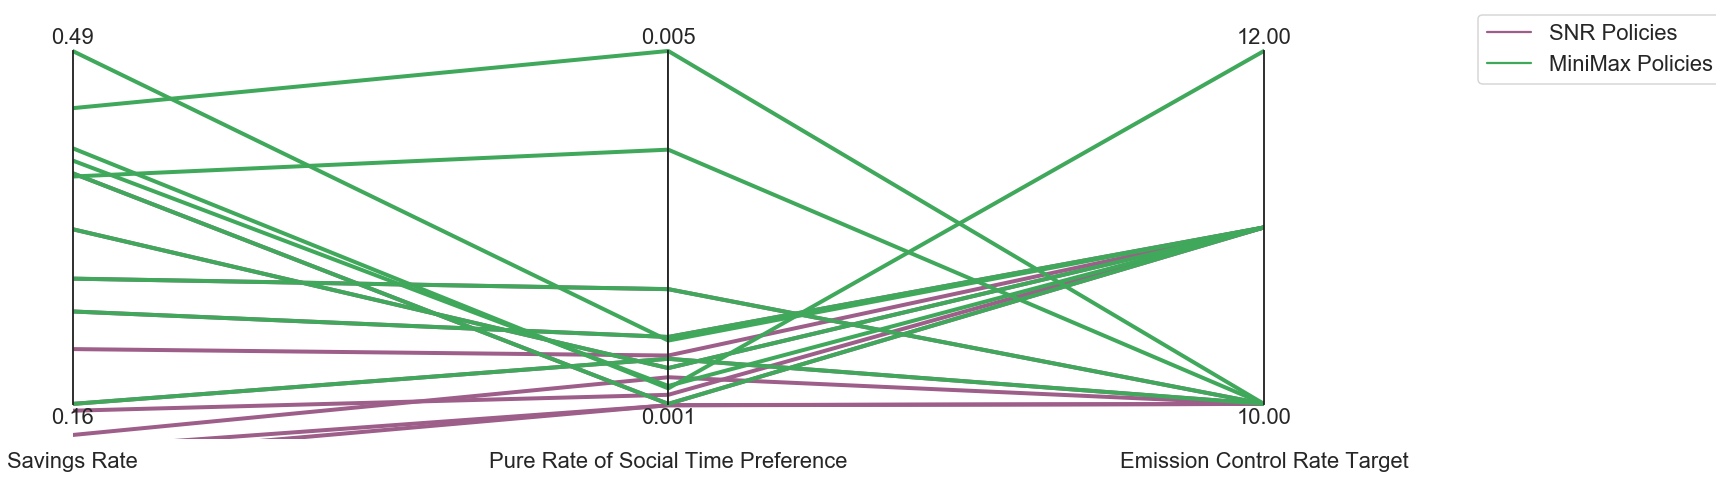

In [92]:
clr_palette = ([(0.66,0.66,0.66),sns.color_palette("inferno", 15)[-3],sns.color_palette("YlGn", 10)[-4],
                sns.color_palette("viridis", 10)[3],sns.cubehelix_palette(10)[5]])

paraxes = parcoords.ParallelAxes(parcoords.get_limits(robpolDF), rot=0, fontsize=22)
paraxes.fig.set_size_inches(20,7)

paraxes.plot(snr_polDF, 
                 linewidth=4,
                 color = clr_palette[4],
                 label = "SNR Policies")
paraxes.plot(robpolDF, 
                 linewidth=4,
                 color = clr_palette[2],
                 label = "MiniMax Policies")
             # paraxes.plot(pd.DataFrame([np.mean(dice_opt.iloc[129]),0.015,28], index = robpolDF.columns).T, 
#              color = 'black',
#              linewidth=4,
#              label = 'Nordhaus Policy')
#plt.gca().legend(bbox_to_anchor=(1.4, 1), fontsize = 15)
#paraxes.invert_axis(stn_scores_columns)
paraxes.legend()
plt.show() 

In [74]:
robpolDF

Savings Rate  Pure Rate of Social Time Preference  \
11      0.401193                             0.001188   
12      0.377313                             0.001020   
14      0.276679                             0.002262   
29      0.389462                             0.001215   
34      0.494000                             0.001705   
64      0.157100                             0.001508   
65      0.374155                             0.003770   
70      0.245337                             0.001744   
72      0.439394                             0.004838   
88      0.323865                             0.001408   

    Emission Control Rate Target  
11                          12.0  
12                          11.0  
14                          10.0  
29                          11.0  
34                          11.0  
64                          10.0  
65                          10.0  
70                          11.0  
72                          10.0  
88                          11.0

In [75]:
snr_polDF

Savings Rate  Pure Rate of Social Time Preference  \
2        0.209431                             0.001544   
12       0.377313                             0.001020   
14       0.276679                             0.002262   
33       0.150607                             0.001119   
64       0.157100                             0.001508   
70       0.245337                             0.001744   
88       0.323865                             0.001408   
101      0.127426                             0.001309   
103      0.114714                             0.001005   
104      0.106083                             0.001007   

     Emission Control Rate Target  
2                            11.0  
12                           11.0  
14                           10.0  
33                           11.0  
64                           10.0  
70                           11.0  
88                           11.0  
101                          10.0  
103                          10.0  
104                          10.0

In [76]:
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [ ]:
policies = snr_polDF.iloc[2,:]

In [ ]:
policies.T.to_csv("policy_12.csv")